In [1]:
# Basic
import numpy as np
import pandas as pd
import random
import time

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Importing
import dask.dataframe as dd

# Methods
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix

from scipy.sparse import csr_matrix, coo_matrix, find

from surprise import Dataset, Reader, SVD

from lightfm import LightFM
from lightfm.data import Dataset

/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# 1. Load Datasets
### Users

In [2]:
users = pd.read_csv('LFM-1b_users.txt', delimiter = '\t', header = 0)

#Users Additional information
users_add = pd.read_csv('LFM-1b_users_additional.txt', delimiter = '\t', header = 0)
users_add.rename(columns={'user-id': 'user_id'}, inplace=True)

### Artists

In [3]:
column_names_artists = ["artist_id", "artist"]
artists = pd.read_csv('LFM-1b_artists.txt', delimiter = '\t', header = None, names=column_names_artists)

### Tracks

In [4]:
tracks = pd.read_csv('LFM-1b_tracks.txt', delimiter = '\t', header = None, index_col = 0)
tracks.columns = ['track_name', 'artist_id']
tracks.index.name = 'track_id'
tracks['track_id'] = tracks.index

### Albums

In [5]:
column_names_albums = ["album_id", "album_name", "artist_id"]
albums = pd.read_csv('LFM-1b_albums.txt', delimiter = '\t', header = None, names=column_names_albums)

### Listening events

In [6]:
columns = ['user_id', 'artist_id', 'album_id', 'track_id', 'timestamp']
LEs = dd.read_csv('LFM-1b_LEs.txt', sep='\t', header=None, names=columns)

In [7]:
# Define a function to limit rows to 1000 per user_id
def limit_rows_partition(partition):
    return partition.groupby('user_id').head(1000)

# Use map_partitions to apply the custom function to each partition
LEs_filtered = LEs.map_partitions(limit_rows_partition, meta=LEs)

# Compute the result if you want to convert it to a pandas dataframe
LEs_filtered = LEs_filtered.compute()

### All genres

In [8]:
all_genres = pd.read_csv('genres_allmusic.txt', delimiter = '\t', header = None)
all_genres = all_genres.rename(columns={0: 'genre'})
all_genres.index.name = 'genre_id'
all_genres['genre_id'] = all_genres.index

### Genres per artist
A dataframe of all artists and their genres they have produced

In [9]:
artist_genres_dict = {}

with open('LFM-1b_artist_genres_allmusic.txt', 'r') as file:
    for line in file:
        fields = line.strip().split('\t')
        artist = fields[0]

        artist_genres_dict[artist] = [int(genre_id) for genre_id in fields[1:]]

# Convert the dictionary to a pandas DataFrame
artist_genres = pd.DataFrame(list(artist_genres_dict.items()),
                             columns=['Artist', 'Genres'])

### Genres listened to per user

In [10]:
UGP = pd.read_csv('LFM-1b_UGP_noPC_allmusic.txt', delimiter = '\t',
                  header = 0, index_col = 0)

In [11]:
UGP_weighted = pd.read_csv('LFM-1b_UGP_weightedPC_allmusic.txt',
                           delimiter = '\t', header = 0, index_col = 0)

# 2. Data Preperation

### Users
I only want to use users for whom country, gender, and age information is available.
That reduces the users from 120322 to 42997

In [12]:
filtered_users = users[(users['country'].notna()) & (users['country'] != 'NaN')
                       & (users['age'] != -1) & users['gender'].notna()]

Drop the column 'registered_unixtime' as it is has no added value

In [13]:
filtered_users = filtered_users.drop('registered_unixtime', axis=1)

I want to merge the dataframes 'filtered users' and users_add. We will call this users_df.
Some users had values '-1' as playcount. These users are filtered out

In [14]:
USERS_DF = filtered_users.merge(users_add, on='user_id', how='inner')
USERS_DF = USERS_DF[USERS_DF['playcount'] > 0]

NAs are replaced by zeros

In [15]:
USERS_DF.replace("?", 0, inplace=True) # Change NAs to 0

The columns Country and Gender are encoded to numeric values

In [16]:
label_encoders = {}
for column in ['country', 'gender']:
    label_encoders[column] = LabelEncoder()
    USERS_DF[f'{column}_id'] = label_encoders[column].fit_transform(USERS_DF[column])

In [17]:
USERS_DF

,user_id,country,age,gender,playcount,novelty_artist_avg_month,novelty_artist_avg_6months,novelty_artist_avg_year,mainstreaminess_avg_month,mainstreaminess_avg_6months,...,relative_le_per_hour16,relative_le_per_hour17,relative_le_per_hour18,relative_le_per_hour19,relative_le_per_hour20,relative_le_per_hour21,relative_le_per_hour22,relative_le_per_hour23,country_id,gender_id
0,384,UK,35,m,42139,0.27662877856116547,0.044439,0.3094285950064659,0.024655,0.36734262481331825,...,0.0811,0.1506,0.0377,0.0298,0.0132,0.0007,0.0001,0.0151,181,1
1,3653,UK,31,m,18504,0.3800046739749389,0.045207,0.4244110181051142,0.042821,0.4917559259467655,...,0.0564,0.0554,0.0849,0.0954,0.0833,0.0657,0.0471,0.0595,181,1
2,4813,US,43,m,640,0.8463672793963376,0.023451,0.9078910708427429,0.025951,0.8961933553218842,...,0.0703,0.1118,0.0829,0.0968,0.1175,0.0518,0.0979,0.1141,183,1
3,5069,AT,30,m,31867,0.4035084552454705,0.039507,0.5526921644806861,0.096027,0.5700561702251434,...,0.0072,0.0081,0.0274,0.0729,0.0974,0.0838,0.1095,0.1315,9,1
4,5213,UK,37,n,392,0.6056802751762527,0.010228,0.8638503551483154,0.008475,0.92367924451828,...,0.0362,0.0798,0.0399,0.081,0.1022,0.0923,0.0187,0.0249,181,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42992,50673825,JP,43,m,39,0.3839772916620686,0.013575,0.4313792735338211,0.032379,0.5190173611044884,...,0.0197,0.0045,0.0017,0.0007,0.0007,0.0011,0.0031,0.013,87,1
42993,50759670,US,25,m,467,0.2298021075129509,0.063232,0.23911124654114246,0.041622,0.3510461077094078,...,0.0183,0.0122,0.0127,0.0176,0.0251,0.0154,0.0281,0.0303,183,1
42994,50796677,PL,110,f,1495,0.44820450246334076,0.027277,0.4848484992980957,0.039423,0,...,0.0731,0.0444,0.0668,0.042,0.096,0.1857,0.0499,0.0016,143,0
42995,50871714,BY,19,f,569,0.4170865923166275,0.035417,0.5498878061771393,0.084304,0.6624909937381744,...,0.0575,0.0558,0.0578,0.0573,0.0515,0.0551,0.0639,0.0641,26,0


For computational reasons, cap the listening events to 2500 per user. Dataframe is called **'users_df_max_le'**
(Isnt necessary I think?)

In [18]:
max_playcount = 2500

users_df_max_le = USERS_DF.copy()
users_df_max_le['playcount'] = users_df_max_le['playcount'].apply(lambda x: min(x, max_playcount))

We compare the mean of users_df to users_df_max_le.
This makes a big difference, and will reduce our dataset a lot

In [19]:
print(USERS_DF['playcount'].mean().round(2))
print(users_df_max_le['playcount'].mean().round(2))

31446.36
2098.74


### Tracks

For computational reasons we will only use artists, tracks, and albums with genre information available.
We start with the artists that have genre available. This reduces the artists from 582550 to 219205.

In [20]:
artist_genres = pd.DataFrame(list(artist_genres_dict.items()), columns=['artist', 'genres'],
                             index=range(1, len(artist_genres_dict) + 1))

artist_genres.index.name = 'artist_id'
artist_genres['artist_id'] = artist_genres.index
artist_genres = artist_genres.rename(columns={'genres': 'genre_id'})

artist_genres = artist_genres[artist_genres['genre_id'].apply(len) > 0] #Only artists with >0 genres

artist_genres.reset_index(drop=True, inplace=True)

artist_genres

,artist,genre_id,artist_id
0,Megadeth,"[19, 3]",1
1,Lil Wayne,"[3, 18, 0]",2
2,Foo Fighters,"[16, 15, 18]",3
3,Porcupine Tree,"[3, 16]",4
4,No-Man,"[2, 3, 16, 18, 12]",5
...,...,...,...
219020,Untertagen,"[18, 3]",582516
219021,Christian Gregory,[0],582525
219022,Jason Feathers,[2],582537
219023,Pete Barnardo Band,[10],582542


Next, I will filter out tracks from artists which are not known in the dataframe artist_genres (i.e. artists who have no genres available). This reduces the tracks from 32,135,384 to 14,189,672

In [21]:
# Extract unique artist_ids from 'artist_genres'
allowed_artist_ids = artist_genres['artist_id'].unique()

# Filter 'tracks' based on 'artist_id'
tracks_with_genres = tracks[tracks['artist_id'].isin(allowed_artist_ids)]

tracks_with_genres.reset_index(drop=True, inplace=True)

tracks_with_genres

,track_name,artist_id,track_id
0,A Matter of Time,3,1
1,Hangar 18,1,2
2,Up the Downstair,4,3
3,Mr. Carter (Featuring Jay-Z),2,4
4,Mixtaped,5,5
...,...,...,...
14189667,All I Need - Performance Track In Key Of Ab,21749,32291130
14189668,Oxygen (In the Style of Colbie Caillat) [Karao...,281827,32291131
14189669,Set The World On Fire - High Key Performance T...,60361,32291132
14189670,Resound,53412,32291133


Now, I will do the same for albums and remove the NaNs for album_name. This reduces the dataframe from 15,934,220 to 7,319,030

In [22]:
albums_with_genres = albums[albums['artist_id'].isin(allowed_artist_ids)]
albums_with_genres = albums_with_genres.dropna(subset=['album_name'])

albums_with_genres

,album_id,album_name,artist_id
0,1,Wasting Light,3
1,2,Rust In Peace,1
2,3,Spiral Circus Live,4
3,4,Tha Carter 3,2
4,5,Schoolyard Ghosts,5
...,...,...,...
15934199,15991018,Platinium Hit Parade II,409375
15934200,15991019,Raï à l'ancienne (Best of des plus grandes sta...,92395
15934215,15991034,Debussy: Prelude to the Afternoon of a Faun - ...,38347
15934218,15991037,lastsleep (1944-1946),82590


In [23]:
MERGED_ARTIST_TRACKS = pd.merge(artist_genres, tracks_with_genres, on='artist_id')
MERGED_ARTIST_TRACKS = MERGED_ARTIST_TRACKS[['artist', 'track_name', 'genre_id', 'artist_id', 'track_id']]

In [24]:
MERGED_ARTIST_TRACKS

,artist,track_name,genre_id,artist_id,track_id
0,Megadeth,Hangar 18,"[19, 3]",1,2
1,Megadeth,Tornado Of Souls,"[19, 3]",1,8
2,Megadeth,Captive Honour,"[19, 3]",1,1524
3,Megadeth,Back In the Day,"[19, 3]",1,1782
4,Megadeth,Train of Consequences,"[19, 3]",1,1784
...,...,...,...,...,...
14189667,Jason Feathers,Once,[2],582537,28517018
14189668,Jason Feathers,Nowhere To Run,[2],582537,28517019
14189669,Jason Feathers,Poker Face,[2],582537,31789377
14189670,Pete Barnardo Band,again !,[10],582542,5526515


In [25]:
# Perform one-hot encoding on the 'genre_id' column
genre_dummies = pd.get_dummies(
    pd.DataFrame(MERGED_ARTIST_TRACKS['genre_id'].tolist(), index=MERGED_ARTIST_TRACKS.index).stack()
)

# Sum the one-hot encoded genre features by grouping on index
genre_dummies = genre_dummies.groupby(level=0).sum()

# Concatenate the one-hot encoded genre features back to the original DataFrame
merged_artist_tracks_encoded = pd.concat([MERGED_ARTIST_TRACKS, genre_dummies], axis=1)

merged_artist_tracks_encoded.rename(columns={0.0: 'genre_0', 1.0: 'genre_1', 2.0: 'genre_2',
                                             3.0: 'genre_3', 4.0: 'genre_4',5.0: 'genre_5',
                                             6.0: 'genre_6', 7.0: 'genre_7',
                                             8.0: 'genre_8', 9.0: 'genre_9', 10.0: 'genre_10',
                                             11.0: 'genre_11', 12.0: 'genre_12', 13.0: 'genre_13',
                                             14.0: 'genre_14', 15.0: 'genre_15', 16.0: 'genre_16',
                                             17.0: 'genre_17', 18.0: 'genre_18', 19.0: 'genre_19',}
                                            , inplace=True)

In [26]:
merged_artist_tracks_encoded

,artist,track_name,genre_id,artist_id,track_id,genre_0,genre_1,genre_2,genre_3,genre_4,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19
0,Megadeth,Hangar 18,"[19, 3]",1,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,Megadeth,Tornado Of Souls,"[19, 3]",1,8,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,Megadeth,Captive Honour,"[19, 3]",1,1524,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,Megadeth,Back In the Day,"[19, 3]",1,1782,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,Megadeth,Train of Consequences,"[19, 3]",1,1784,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14189667,Jason Feathers,Once,[2],582537,28517018,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14189668,Jason Feathers,Nowhere To Run,[2],582537,28517019,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14189669,Jason Feathers,Poker Face,[2],582537,31789377,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14189670,Pete Barnardo Band,again !,[10],582542,5526515,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
LISTENING_EVENTS = LEs_filtered[
    LEs_filtered['user_id'].isin(USERS_DF['user_id']) &
    LEs_filtered['track_id'].isin(MERGED_ARTIST_TRACKS['track_id']) &
    LEs_filtered['artist_id'].isin(MERGED_ARTIST_TRACKS['artist_id']) &
    LEs_filtered['album_id'].isin(albums_with_genres['album_id'])
]

In [28]:
LISTENING_EVENTS = LISTENING_EVENTS.merge(MERGED_ARTIST_TRACKS[['track_id', 'track_name', 'artist']], on='track_id', how='left')

In [29]:
LISTENING_EVENTS

,user_id,artist_id,album_id,track_id,timestamp,track_name,artist
0,31435741,2,4,4,1385212958,Mr. Carter (Featuring Jay-Z),Lil Wayne
1,31435741,2,4,4,1385212642,Mr. Carter (Featuring Jay-Z),Lil Wayne
2,31435741,2,4,4,1385212325,Mr. Carter (Featuring Jay-Z),Lil Wayne
3,31435741,2,4,4,1385209508,Mr. Carter (Featuring Jay-Z),Lil Wayne
4,31435741,2,4,4,1385209191,Mr. Carter (Featuring Jay-Z),Lil Wayne
...,...,...,...,...,...,...,...
18659313,5452750,2539,5459,19593,1362648506,The Cave,Garage Hymnal
18659314,5452750,3059,114114,339621,1362568139,"Detroit, Lift Up Your Weary Head! (Rebuild! Re...",Junior Murvin
18659315,5452750,6286,7729365,34675,1362567885,Chan Chan,Astronauts
18659316,5452750,45,8801595,339568,1362567694,Shine On,The Kooks


# 3. Exploratory Data Analysis

### Age Distribution

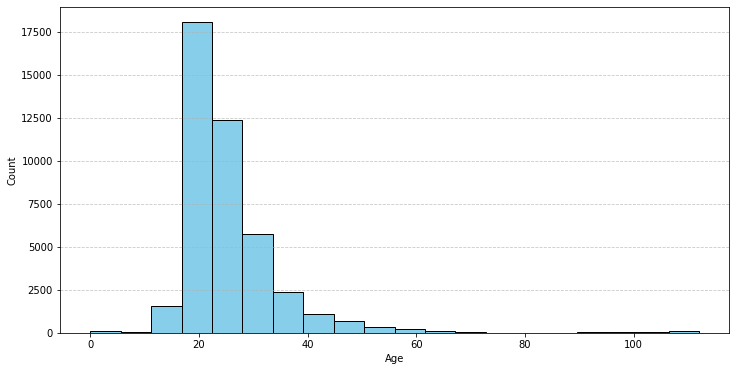

In [30]:
plt.figure(figsize=(12, 6))
plt.hist(USERS_DF['age'], bins=20, color='skyblue', edgecolor='black')
#plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('age_distr.png')
plt.show()

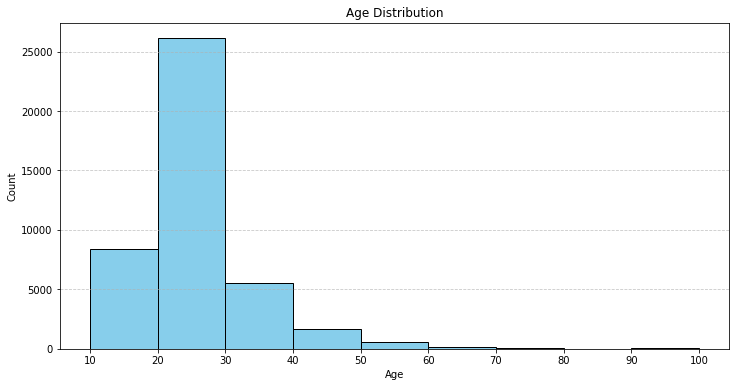

In [31]:
age_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(12, 6))
plt.hist(USERS_DF['age'], bins=age_bins, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(age_bins)
#plt.savefig('age_distribution.png')
plt.show()

### Country Distribution

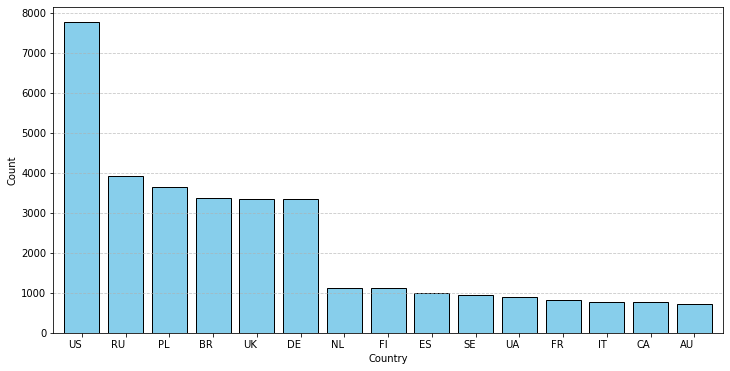

In [32]:
top_countries = USERS_DF['country'].value_counts().head(15)

plt.figure(figsize=(12, 6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8)
#plt.title('Top 15 Country Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, ha='right')
#plt.savefig('country_distr.png')
plt.show()

### Gender Distribution

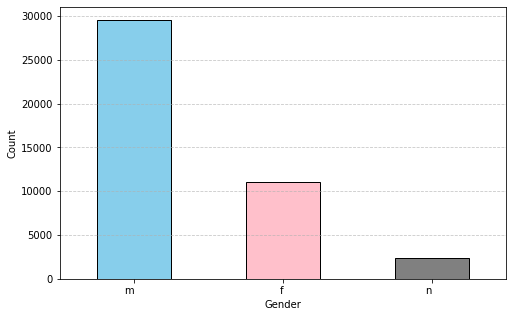

In [33]:
plt.figure(figsize=(8, 5))
gender_distribution = USERS_DF['gender'].value_counts()
gender_distribution.plot(kind='bar', color=['skyblue', 'pink', 'grey'], edgecolor='black')
#plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, ha='right')
#plt.savefig('gender_distr.png')
plt.show()

### Density plot; users_df VS users_df_max_le

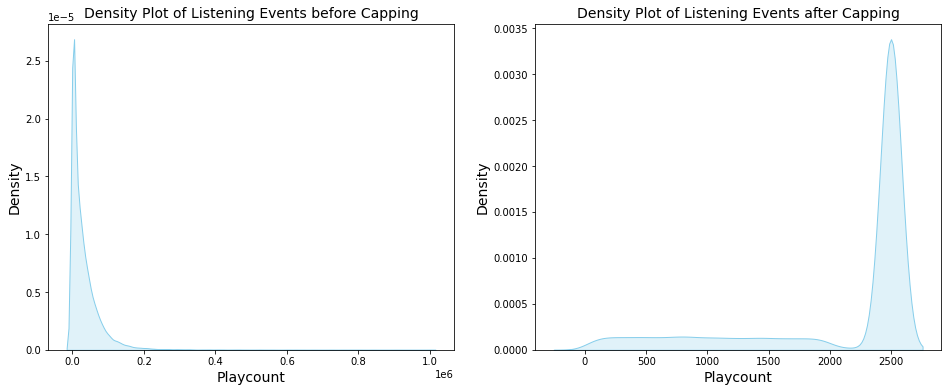

In [34]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(USERS_DF['playcount'], fill=True, color='skyblue')
plt.xlabel('Playcount', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title("Density Plot of Listening Events before Capping", fontsize=14)

plt.subplot(1, 2, 2)
sns.kdeplot(users_df_max_le['playcount'], fill=True, color='skyblue')
plt.xlabel('Playcount', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title("Density Plot of Listening Events after Capping", fontsize=14)

#plt.savefig('density plots playcount')

plt.show()

### Density plots of Tracks and Artists

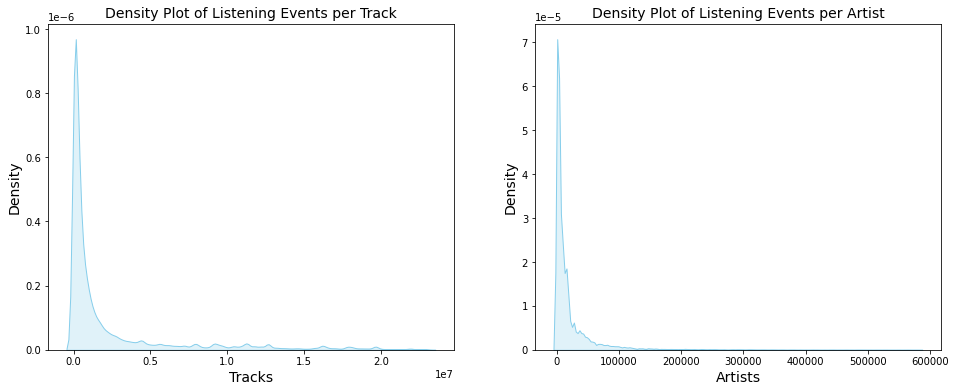

In [35]:
songs_df = LISTENING_EVENTS[['track_id', 'user_id']]
artists_df = LISTENING_EVENTS[['artist_id', 'user_id']]

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=songs_df, x='track_id', fill=True, color='skyblue')
plt.xlabel('Tracks', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density Plot of Listening Events per Track', fontsize=14)

plt.subplot(1, 2, 2)
sns.kdeplot(data=artists_df, x='artist_id', fill=True, color='skyblue')
plt.xlabel('Artists', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density Plot of Listening Events per Artist', fontsize=14)

#plt.savefig('density plots tracks artists')

plt.show()

# 4. Methods

## 4.1 Content-Based Filtering

### 4.1.1 Baseline Content-Based Filtering
- Random users: 500
- Recommendation list size: 10, 25 & 50
- Max Songs per Artist = 3

In [ ]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 10
max_songs_per_artist = 3

#-----------------------------------------------------------------------------------#

# Artists
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#-----------------------------------------------------------------------------------#

# Genres
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#-----------------------------------------------------------------------------------#

# List containing all recommended artists
all_recommendations_pred_list = []

#-----------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
# Iterate through random users
for _ in range(num_random_users):
    random_user = USERS_DF.sample(n=1)  # Get a random user
    user_id = random_user['user_id'].values[0]
    
    # Get demographic features of the random user
    age = random_user['age'].values[0]
    gender_id = random_user['gender_id'].values[0]
    country_id = random_user['country_id'].values[0]

    # Find users with the same age, gender_id, and country_id
    similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                             (USERS_DF['gender_id'] == gender_id) & 
                             (USERS_DF['country_id'] == country_id) &
                             (USERS_DF['user_id'] != user_id)] # Exclude random user
    
    if similar_users.empty:
        continue

    # Get the combined most listened tracks for similar users
    similar_user_ids = similar_users['user_id'].tolist()

    # Filter listening events for similar users
    filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]

    # Count occurrences of each track_id
    track_counts_pred = filtered_df_pred['track_id'].value_counts()

    # Get the top N most listened tracks
    top_similar_tracks_pred = track_counts_pred

    # Create a DataFrame for the top N most listened tracks
    top_df_pred = pd.DataFrame({
        'Track ID': top_similar_tracks_pred.index,
        'Track Name': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_similar_tracks_pred.index],
        'Artist': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['artist'].iloc[0] for track_id in top_similar_tracks_pred.index],
        'Count': top_similar_tracks_pred.values
    })

    most_listened_track_id = None  # Initialize most_listened_track_id to None
    if not filtered_df_pred.empty:
        most_listened_track_id = filtered_df_pred['track_id'].value_counts().idxmax()  # Most listened track_id

    # Check if most_listened_track_id is not None before further processing
    if most_listened_track_id is not None:
        # Get features of the most listened track
        most_listened_track_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == most_listened_track_id][['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Get features of ALL other tracks
    all_track_features = merged_artist_tracks_encoded[['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Calculate cosine similarities between the most listened song and all other tracks
    CB_similarities_pred = cosine_similarity(most_listened_track_features, all_track_features)

    similar_songs_indices_pred = []
    artist_count_pred = {}

    for index in CB_similarities_pred.argsort()[0][::-1]:
        row = merged_artist_tracks_encoded.iloc[index]
        artist = row['artist']

        # Include the song if the artist isn't in the list yet
        if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
            similar_songs_indices_pred.append(index)
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist) # Used for coverage

            artist_count_pred[artist] = artist_count_pred.get(artist, 0) + 1

        # Stop if the recommendation list size reaches max list size
        if len(similar_songs_indices_pred) >= recommendation_list_size:
            break

    # Create predicted recommendation list
    CB_recommendation_list_pred = merged_artist_tracks_encoded.loc[similar_songs_indices_pred][['artist', 'track_name', 'track_id', 'genre_id']]
    
    # --------------------------------------------------------------------------------------------------------- #

    # Get the actual recommendation list for the user
    CB_actual_user_id = user_id

    # Filter listening events
    filtered_df_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'] == CB_actual_user_id]

    # Count occurrences of each track_id
    track_counts_actual = filtered_df_actual['track_id'].value_counts()

    # Get the top N most listened tracks
    top_tracks_actual = track_counts_actual.head(3)

    # Create a DataFrame for the top N most listened tracks
    top_tracks_actual_df = pd.DataFrame({
        'Track ID': top_tracks_actual.index,
        'Track Name': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_tracks_actual.index],
        'Artist': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['artist'].iloc[0] for track_id in top_tracks_actual.index],
        'Count': top_tracks_actual.values })

    top_song_id_actual = None  # Initialize most_listened_track_id to None
    if not filtered_df_actual.empty:
        top_song_id_actual = filtered_df_actual['track_id'].value_counts().idxmax()  # Most listened track_id

    # Check if most_listened_track_id is not None before further processing
    if top_song_id_actual is not None:
        # Get features of the most listened track
        top_song_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == top_song_id_actual][['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Get features of ALL other tracks
    all_track_features = merged_artist_tracks_encoded[['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Calculate cosine similarities between the most listened song and all other tracks
    CB_similarities_actual = cosine_similarity(top_song_features, all_track_features)

    similar_songs_indices_actual = []
    artist_count_actual = {}

    for index in CB_similarities_actual.argsort()[0][::-1]:
        row = merged_artist_tracks_encoded.iloc[index]
        artist = row['artist']

        # Include the song if the artist isn't in the list yet
        if artist not in artist_count_actual or artist_count_actual[artist] < max_songs_per_artist:
            similar_songs_indices_actual.append(index)

        artist_count_actual[artist] = artist_count_actual.get(artist, 0) + 1

        # Stop if the recommendation list size reaches recommendation_list_size
        if len(similar_songs_indices_actual) >= recommendation_list_size:
            break

    # Create actual recommendation list
    CB_recommendation_list_actual = merged_artist_tracks_encoded.loc[similar_songs_indices_actual][['artist', 'track_name', 'track_id', 'genre_id']]

    # --------------------------------------------------------------------------------------------------------- #
    
    # Compare the predicted and actual recommendation lists for evaluation (based on artists)
    pred_artists = CB_recommendation_list_pred['artist'].tolist()
    actual_artists = CB_recommendation_list_actual['artist'].tolist()
    
    common_artists = set(pred_artists).intersection(actual_artists)
    TP_artists = len(common_artists)
    FN_artists = len(set(pred_artists) - common_artists)
    FP_artists = len(set(actual_artists) - common_artists)
    
    # --------------------------------------------------------------------------------------------------------- #
    
    # Compare the predicted and actual recommendation lists for evaluation (based on genres)
    pred_genres = [set(genre_list) for genre_list in CB_recommendation_list_pred['genre_id']]
    actual_genres = [set(genre_list) for genre_list in CB_recommendation_list_actual['genre_id']]

    TP_genres = 0
    FN_genres = 0
    FP_genres = 0

    # Iterate through genres in the predicted genres list
    for pred_genre_set in pred_genres:
        if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
            TP_genres += 1
        else:
            FP_genres += 1

    FN_genres = len(pred_genres) - TP_genres
    
    # --------------------------------------------------------------------------------------------------------- #
    
    precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
    recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
    f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

    tp_values_artists.append(TP_artists)
    fn_values_artists.append(FN_artists)
    fp_values_artists.append(FP_artists)
    precision_values_artists.append(precision_artists)
    recall_values_artists.append(recall_artists)
    f1_score_values_artists.append(f1_score_artists)
    
    # --------------------------------------------------------------------------------------------------------- #
    
    precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
    recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
    f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0

    tp_values_genres.append(TP_genres)
    fn_values_genres.append(FN_genres)
    fp_values_genres.append(FP_genres)
    precision_values_genres.append(precision_genres)
    recall_values_genres.append(recall_genres)
    f1_score_values_genres.append(f1_score_genres)
       
execution_time = time.time() - start_time
print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Baseline CB

In [ ]:
# ARTIST DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Baseline CB

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.4f}")

#### Spread

In [ ]:
spread = np.std(CB_similarities_pred)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = CB_similarities_pred.mean()
print("Intra List Similarity:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.2f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.2f}%".format(APL))

### 4.1.2 Tuned Content-Based Filtering
- Random users: 500
- Recommendation list size: 10, 25 & 50

##### How did I tune?
- Max Songs per Artist = 1
- Use all genres from top 5 tracks to make recommendations

In [47]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 10
max_songs_per_artist = 1

#-----------------------------------------------------------------------------------#

# Artists
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#-----------------------------------------------------------------------------------#

# Genres
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#-----------------------------------------------------------------------------------#

# List containing all recommended artists
all_recommendations_pred_list = []

#-----------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
# Iterate through random users
for _ in range(num_random_users):
    # Get a random user from USERS_DF
    random_user = USERS_DF.sample(n=1)  # Get a random user
    user_id = random_user['user_id'].values[0]
    
    # Get demographic features of the random user
    age = random_user['age'].values[0]
    gender_id = random_user['gender_id'].values[0]
    country_id = random_user['country_id'].values[0]

    # Find users with the same age, gender_id, and country_id
    similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                             (USERS_DF['gender_id'] == gender_id) & 
                             (USERS_DF['country_id'] == country_id) &
                             (USERS_DF['user_id'] != user_id)] # Exclude random user
    
    if similar_users.empty:
        continue

    # Get the combined most listened tracks for similar users
    similar_user_ids = similar_users['user_id'].tolist()

    # Filter listening events for similar users
    filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]

    # Count occurrences of each track_id
    track_counts_pred = filtered_df_pred['track_id'].value_counts()

    # Get the top 5 most listened tracks for similar users
    top_similar_tracks_pred = track_counts_pred.nlargest(5)

    # Create a DataFrame for the top 5 most listened tracks
    top_df_pred = pd.DataFrame({
        'Track ID': top_similar_tracks_pred.index,
        'Track Name': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_similar_tracks_pred.index],
        'Artist': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['artist'].iloc[0] for track_id in top_similar_tracks_pred.index],
        'Count': top_similar_tracks_pred.values
    })

    most_listened_track_ids = None  
    if not filtered_df_pred.empty:
        top_5_most_listened_track_ids = filtered_df_pred['track_id'].value_counts().nlargest(5).index.tolist()  # Top 5 most listened track_ids

    # Check if top_5_most_listened_track_ids is not empty before further processing
    if top_5_most_listened_track_ids:
        # Get features of the top 5 most listened tracks
        most_listened_track_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'].isin(top_5_most_listened_track_ids)][['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]
    else:
        # Handle the case when there are no top listened tracks for the user
        most_listened_track_features = None

    # Get features of ALL other tracks
    all_track_features = merged_artist_tracks_encoded[['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Calculate cosine similarities between the most listened song and all other tracks
    CB_similarities_pred = cosine_similarity(most_listened_track_features, all_track_features)
    
    similar_songs_indices_pred = []
    artist_count_pred = {}

    for index in CB_similarities_pred.argsort()[0][::-1]:
        row = merged_artist_tracks_encoded.iloc[index]
        artist = row['artist']

        # Include the song if the artist isn't in the list yet
        if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
            similar_songs_indices_pred.append(index)
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist) # Used for coverage

            artist_count_pred[artist] = artist_count_pred.get(artist, 0) + 1

        # Stop if the recommendation list size reaches max list size
        if len(similar_songs_indices_pred) >= recommendation_list_size:
            break

    # Create predicted recommendation list
    CB_recommendation_list_pred = merged_artist_tracks_encoded.loc[similar_songs_indices_pred][['artist', 'track_name', 'track_id', 'genre_id']]
    print(CB_recommendation_list_pred)
    # -------------------------------------------------------------------------------------------------------------- #
    
    # Get the actual recommendation list for the user
    CB_actual_user_id = user_id

    # Filter listening events
    filtered_df_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'] == CB_actual_user_id]

    # Count occurrences of each track_id
    track_counts_actual = filtered_df_actual['track_id'].value_counts()

    # Get the top N most listened tracks
    top_tracks_actual = track_counts_actual.head(3)

    # Create a DataFrame for the top N most listened tracks
    top_tracks_actual_df = pd.DataFrame({
        'Track ID': top_tracks_actual.index,
        'Track Name': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_tracks_actual.index],
        'Artist': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['artist'].iloc[0] for track_id in top_tracks_actual.index],
        'Count': top_tracks_actual.values })
    
    top_song_id_actual = None  # Initialize most_listened_track_id to None
    if not filtered_df_actual.empty:
        top_song_id_actual = filtered_df_actual['track_id'].value_counts().idxmax()  # Most listened track_id

    # Check if most_listened_track_id is not None before further processing
    if top_song_id_actual is not None:
        # Get features of the most listened track
        top_song_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == top_song_id_actual][['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Get features of ALL other tracks
    all_track_features = merged_artist_tracks_encoded[['artist_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

    # Calculate cosine similarities between the most listened song and all other tracks
    CB_similarities_actual = cosine_similarity(top_song_features, all_track_features)

    similar_songs_indices_actual = []
    artist_count_actual = {}

    for index in CB_similarities_actual.argsort()[0][::-1]:
        row = merged_artist_tracks_encoded.iloc[index]
        artist = row['artist']

        # Include the song if the artist isn't in the list yet
        if artist not in artist_count_actual or artist_count_actual[artist] < max_songs_per_artist:
            similar_songs_indices_actual.append(index)

        # Update the count of similar songs for the artist
        artist_count_actual[artist] = artist_count_actual.get(artist, 0) + 1

        # Stop if the recommendation list size reaches recommendation_list_size
        if len(similar_songs_indices_actual) >= recommendation_list_size:
            break

    # Create actual recommendation list
    CB_recommendation_list_actual = merged_artist_tracks_encoded.loc[similar_songs_indices_actual][['artist', 'track_name', 'track_id', 'genre_id']]
    print(CB_recommendation_list_actual)
    # --------------------------------------------------------------------------------------------------------- #
    
    # Compare the predicted and actual recommendation lists for evaluation (based on artists)
    pred_artists = CB_recommendation_list_pred['artist'].tolist()
    actual_artists = CB_recommendation_list_actual['artist'].tolist()

    common_artists = set(pred_artists).intersection(actual_artists)
    TP_artists = len(common_artists)
    FN_artists = len(set(pred_artists) - common_artists)
    FP_artists = len(set(actual_artists) - common_artists)
    
    # --------------------------------------------------------------------------------------------------------- #
    
    # Compare the predicted and actual recommendation lists for evaluation (based on genres)
    pred_genres = [set(genre_list) for genre_list in CB_recommendation_list_pred['genre_id']]
    actual_genres = [set(genre_list) for genre_list in CB_recommendation_list_actual['genre_id']]

    TP_genres = 0
    FN_genres = 0
    FP_genres = 0

    # Iterate through genres in the predicted genres list
    for pred_genre_set in pred_genres:
        # Check if there's a common genre with the actual genres
        if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
            TP_genres += 1
        else:
            FP_genres += 1

    FN_genres = len(pred_genres) - TP_genres
    
    # --------------------------------------------------------------------------------------------------------- #

    precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
    recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
    f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

    tp_values_artists.append(TP_artists)
    fn_values_artists.append(FN_artists)
    fp_values_artists.append(FP_artists)
    precision_values_artists.append(precision_artists)
    recall_values_artists.append(recall_artists)
    f1_score_values_artists.append(f1_score_artists)
    
    # --------------------------------------------------------------------------------------------------------- #
    
    precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
    recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
    f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0

    tp_values_genres.append(TP_genres)
    fn_values_genres.append(FN_genres)
    fp_values_genres.append(FP_genres)
    precision_values_genres.append(precision_genres)
    recall_values_genres.append(recall_genres)
    f1_score_values_genres.append(f1_score_genres)
       
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Tuned CB

In [ ]:
# ARTIST DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Tuned CB

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.4f}")

#### Spread

In [ ]:
spread = np.std(CB_similarities_pred)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = CB_similarities_pred.mean()

print("Intra List Similarity:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.2f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.2f}%".format(APL))

## 4.2 Collaborative Filtering

### 4.2.1 Baseline Collaborative Filtering
- SVD
- Random users: 500
- Recommendation list size: 10, 25 & 50
- Max Songs per Artist = 3

In [ ]:
selected_features = ['gender_id', 'country_id', 'age','novelty_artist_avg_month', 'novelty_artist_avg_6months', 'novelty_artist_avg_year','mainstreaminess_avg_month', 'mainstreaminess_avg_6months', 'mainstreaminess_avg_year', 'mainstreaminess_global','cnt_listeningevents', 'cnt_distinct_tracks', 'cnt_distinct_artists', 'cnt_listeningevents_per_week', 'relative_le_per_weekday1', 'relative_le_per_weekday2', 'relative_le_per_weekday3', 'relative_le_per_weekday4','relative_le_per_weekday5', 'relative_le_per_weekday6', 'relative_le_per_weekday7', 'relative_le_per_hour0', 'relative_le_per_hour1', 'relative_le_per_hour2', 'relative_le_per_hour3', 'relative_le_per_hour4', 'relative_le_per_hour5', 'relative_le_per_hour6', 'relative_le_per_hour7', 'relative_le_per_hour8', 'relative_le_per_hour9', 'relative_le_per_hour10', 'relative_le_per_hour11', 'relative_le_per_hour12', 'relative_le_per_hour13', 'relative_le_per_hour14', 'relative_le_per_hour15', 'relative_le_per_hour16', 'relative_le_per_hour17', 'relative_le_per_hour18', 'relative_le_per_hour19', 'relative_le_per_hour20', 'relative_le_per_hour21', 'relative_le_per_hour22', 'relative_le_per_hour23']

In [ ]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 10
max_songs_per_artist = 3

#-----------------------------------------------------------------------------------#

# Define the Surprise Reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

#-----------------------------------------------------------------------------------#

# Artists
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#-----------------------------------------------------------------------------------#

# Genres
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#-----------------------------------------------------------------------------------#

all_recommendations_pred_list = [] # List containing all recommended artists
cosine_similarities_pred_list = [] # List containing all cosine similarities

#-----------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
from surprise import Dataset
all_track_features = merged_artist_tracks_encoded[['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

for _ in range(num_random_users):
    try:
        # Get a random user from USERS_DF
        random_user = USERS_DF.sample(n=1)  
        user_id = random_user['user_id'].values[0]
    
        # Get demographic features of the random user
        age = random_user['age'].values[0]
        gender_id = random_user['gender_id'].values[0]
        country_id = random_user['country_id'].values[0]

        # Find users with the same age, gender_id, and country_id
        similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                                 (USERS_DF['gender_id'] == gender_id) & 
                                 (USERS_DF['country_id'] == country_id) &
                                 (USERS_DF['user_id'] != user_id)] # Exclude random user
    
        if similar_users.empty:
            continue

        # Get the combined most listened tracks for similar users
        similar_user_ids = similar_users['user_id'].tolist()

        # Filter listening events for similar users
        filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]
    
        user_artist_matrix_pred = pd.pivot_table(filtered_df_pred, index='user_id', columns='track_id', aggfunc='size', fill_value=0)

        # Calculate total plays per user
        user_total_plays_pred = user_artist_matrix_pred.sum(axis=1)

        # Normalize the user-artist matrix
        normalized_user_artist_matrix_pred = user_artist_matrix_pred.divide(user_total_plays_pred, axis=0)

        # Create a sparse matrix with user_id and track_id information
        sparse_matrix_pred = coo_matrix(normalized_user_artist_matrix_pred.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_pred)

        # Create a dataframe (user, item, rating) from elements we found above
        df_pred = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})
        
        data_pred = Dataset.load_from_df(df_pred[['user', 'item', 'rating']], reader)

        trainset_pred = data_pred.build_full_trainset()

        # Use the SVD algorithm
        algorithm_pred = SVD()

        # Train the model on the subset
        algorithm_pred.fit(trainset_pred)

        all_item_ids_pred = df_pred['item'].unique()
        item_ratings_pred = [(item_id, algorithm_pred.predict(user_id, item_id).est) for item_id in all_item_ids_pred]

        # Sort the item_ratings list by predicted rating in descending order
        item_ratings_pred.sort(key=lambda x: x[1], reverse=True)

        top_n = recommendation_list_size
    
        similar_songs_indices_pred = []
        artist_count_pred = {}

        # Iterate through similar songs indices with max_songs_per_artist constraint
        for item_id, _ in item_ratings_pred:
            if item_id not in MERGED_ARTIST_TRACKS['track_id'].values:
                continue
            
            row = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'] == item_id]
            artist = row['artist'].values[0]

            # Include the song if the artist isn't in the list yet and doesn't exceed max_songs_per_artist
            if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
                similar_songs_indices_pred.append(item_id)
        
                # Update the count of similar songs for the artist
                artist_count_pred[artist] = artist_count_pred.get(artist, 0) + 1

            # Stop if the recommendation list size reaches recommendation_list_size
            if len(similar_songs_indices_pred) >= recommendation_list_size:
                break

        CF_recommendation_list_pred = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(similar_songs_indices_pred)]
    
        unique_artists_from_CF = CF_recommendation_list_pred['artist'].unique()

        # Add unique artists to all_recommendations_pred_list
        for artist in unique_artists_from_CF:
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist)  # Used for coverage   
    
    
        track_indices = CF_recommendation_list_pred.index

        # Extract track features from merged_artist_tracks_encoded 
        if len(track_indices) > 0:
            track_features_pred = merged_artist_tracks_encoded.loc[track_indices, 
                                                       ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 
                                                        'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 
                                                        'genre_10', 'genre_11', 'genre_12', 'genre_13', 
                                                        'genre_14', 'genre_15', 'genre_16', 'genre_17', 
                                                        'genre_18', 'genre_19']]

            # Calculate cosine similarities between tracks in CB_recommendation_list_pred
            cosine_similarities_pred = cosine_similarity(track_features_pred, track_features_pred)
            mean_cosine_similarity_pred = cosine_similarities_pred.mean()
            cosine_similarities_pred_list.append(mean_cosine_similarity_pred)

# ----------------------------------------------------------------------------------------------------- #

        random_user_features = random_user[selected_features].values
    
        cosine_similarities = cosine_similarity(random_user_features, USERS_DF[selected_features].values)

        N = 30 

        top_N_similar_users_indices = np.argsort(cosine_similarities[0])[-N-1:-1][::-1]  # -1 to exclude the random user itself

        # Get the top-N most similar users' information
        top_N_similar_users = USERS_DF.iloc[top_N_similar_users_indices]
    
        # Extract top N similar users' user_ids
        top_similar_users_actual = USERS_DF.iloc[top_N_similar_users_indices]['user_id'].tolist()

        # Filter LISTENING_EVENTS to keep only rows corresponding to top N similar users
        filtered_LEs_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(top_similar_users_actual)]
    
        # Create user-item matrix for actual similar users
        user_artist_matrix_actual = pd.pivot_table(filtered_LEs_actual, index='user_id', columns='track_id', aggfunc='size', fill_value=0)
    
        user_total_plays_actual = user_artist_matrix_actual.sum(axis=1)
        normalized_user_artist_matrix_actual = user_artist_matrix_actual.divide(user_total_plays_actual, axis=0)

        # Create sparse matrix for actual similar users
        sparse_matrix_actual = coo_matrix(normalized_user_artist_matrix_actual.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_actual)

        # Create a dataframe (user, item, rating) from elements we found above
        df_actual = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})

        data_actual = Dataset.load_from_df(df_actual[['user', 'item', 'rating']], reader)
    
        trainset_actual = data_actual.build_full_trainset()

        # Use the SVD algorithm for actual similar users
        algorithm_actual = SVD()

        algorithm_actual.fit(trainset_actual)

        all_item_ids_actual = df_actual['item'].unique()
        item_ratings_actual = [(item_id, algorithm_actual.predict(user_id, item_id).est) for item_id in all_item_ids_actual]
    
        # Sort the item_ratings list by actual rating in descending order
        item_ratings_actual.sort(key=lambda x: x[1], reverse=True)

        similar_songs_indices_actual = []
        artist_count_actual = {}

        for item_id, _ in item_ratings_actual:
            if item_id not in MERGED_ARTIST_TRACKS['track_id'].values:
                continue
            
            row = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'] == item_id]
            artist = row['artist'].values[0]

            # Include the song if the artist isn't in the list yet and doesn't exceed max_songs_per_artist
            if artist not in artist_count_actual or artist_count_actual[artist] < max_songs_per_artist:
                similar_songs_indices_actual.append(item_id)
        
                # Update the count of similar songs for the artist
                artist_count_actual[artist] = artist_count_actual.get(artist, 0) + 1

            # Stop if the recommendation list size reaches recommendation_list_size
            if len(similar_songs_indices_actual) >= recommendation_list_size:
                break

        CF_recommendation_list_actual = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(similar_songs_indices_actual)]

# --------------------------------------------------------------------------------------------------------- #

        # Compare the predicted and actual recommendation lists for evaluation (based on artists)
        pred_artists = CF_recommendation_list_pred['artist'].tolist()
        actual_artists = CF_recommendation_list_actual['artist'].tolist()

        common_artists = set(pred_artists).intersection(actual_artists)
        TP_artists = len(common_artists)
        FN_artists = len(set(pred_artists) - common_artists)
        FP_artists = len(set(actual_artists) - common_artists)

# --------------------------------------------------------------------------------------------------------- #

        # Extract unique genres for predicted and actual recommendation lists
        pred_genres = [set(genre_list) for genre_list in CF_recommendation_list_pred['genre_id']]
        actual_genres = [set(genre_list) for genre_list in CF_recommendation_list_actual['genre_id']]

        TP_genres = 0
        FN_genres = 0
        FP_genres = 0

        # Iterate through genres in the predicted genres list
        for pred_genre_set in pred_genres:
            # Check if there's a common genre with the actual genres
            if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
                TP_genres += 1
            else:
                FP_genres += 1

        FN_genres = len(pred_genres) - TP_genres

# --------------------------------------------------------------------------------------------------------- #

        precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
        recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
        f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

        precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
        recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
        f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0
    
# --------------------------------------------------------------------------------------------------------- #

        tp_values_artists.append(TP_artists)
        fn_values_artists.append(FN_artists)
        fp_values_artists.append(FP_artists)
        precision_values_artists.append(precision_artists)
        recall_values_artists.append(recall_artists)
        f1_score_values_artists.append(f1_score_artists)

        tp_values_genres.append(TP_genres)
        fn_values_genres.append(FN_genres)
        fp_values_genres.append(FP_genres)
        precision_values_genres.append(precision_genres)
        recall_values_genres.append(recall_genres)
        f1_score_values_genres.append(f1_score_genres)
        
    except (TypeError, RuntimeWarning) as e:
        print(f"Error: {e}. Skipping this iteration.")
        continue
    
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Baseline CF

In [ ]:
# ARTIST DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Baseline CF

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.4f}")

#### Spread

In [ ]:
spread = np.std(CB_similarities_pred)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = CB_similarities_pred.mean()

print("Intra List Similarity:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.2f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.2f}%".format(APL))

### 4.2.2 Tuned Collaborative Filtering
- SVD
- Random users: 500
- Recommendation list size: 10, 25 & 50

##### How did I tune?
- Max Songs per Artist = 1
- Increased regularization penalty

In [ ]:
selected_features = ['gender_id', 'country_id', 'age','novelty_artist_avg_month', 'novelty_artist_avg_6months', 'novelty_artist_avg_year','mainstreaminess_avg_month', 'mainstreaminess_avg_6months', 'mainstreaminess_avg_year', 'mainstreaminess_global','cnt_listeningevents', 'cnt_distinct_tracks', 'cnt_distinct_artists', 'cnt_listeningevents_per_week', 'relative_le_per_weekday1', 'relative_le_per_weekday2', 'relative_le_per_weekday3', 'relative_le_per_weekday4','relative_le_per_weekday5', 'relative_le_per_weekday6', 'relative_le_per_weekday7', 'relative_le_per_hour0', 'relative_le_per_hour1', 'relative_le_per_hour2', 'relative_le_per_hour3', 'relative_le_per_hour4', 'relative_le_per_hour5', 'relative_le_per_hour6', 'relative_le_per_hour7', 'relative_le_per_hour8', 'relative_le_per_hour9', 'relative_le_per_hour10', 'relative_le_per_hour11', 'relative_le_per_hour12', 'relative_le_per_hour13', 'relative_le_per_hour14', 'relative_le_per_hour15', 'relative_le_per_hour16', 'relative_le_per_hour17', 'relative_le_per_hour18', 'relative_le_per_hour19', 'relative_le_per_hour20', 'relative_le_per_hour21', 'relative_le_per_hour22', 'relative_le_per_hour23']

In [ ]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 10
max_songs_per_artist = 1

#-----------------------------------------------------------------------------------#

# Define the Surprise Reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

#-----------------------------------------------------------------------------------#

# Artists
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#-----------------------------------------------------------------------------------#

# Genres
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#-----------------------------------------------------------------------------------#

all_recommendations_pred_list = [] # List containing all recommended artists
cosine_similarities_pred_list = [] # List containing all cosine similarities

#-----------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
from surprise import Dataset
all_track_features = merged_artist_tracks_encoded[['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

for _ in range(num_random_users):
    try:
        # Get a random user from USERS_DF
        random_user = USERS_DF.sample(n=1)  
        user_id = random_user['user_id'].values[0]
    
        # Get demographic features of the random user
        age = random_user['age'].values[0]
        gender_id = random_user['gender_id'].values[0]
        country_id = random_user['country_id'].values[0]

        # Find users with the same age, gender_id, and country_id
        similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                                 (USERS_DF['gender_id'] == gender_id) & 
                                 (USERS_DF['country_id'] == country_id) &
                                 (USERS_DF['user_id'] != user_id)] # Exclude random user
    
        if similar_users.empty:
            continue

        # Get the combined most listened tracks for similar users
        similar_user_ids = similar_users['user_id'].tolist()

        # Filter listening events for similar users
        filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]
    
        user_artist_matrix_pred = pd.pivot_table(filtered_df_pred, index='user_id', columns='track_id', aggfunc='size', fill_value=0)

        # Calculate total plays per user
        user_total_plays_pred = user_artist_matrix_pred.sum(axis=1)

        # Normalize the user-artist matrix
        normalized_user_artist_matrix_pred = user_artist_matrix_pred.divide(user_total_plays_pred, axis=0)

        # Create a sparse matrix with user_id and track_id information
        sparse_matrix_pred = coo_matrix(normalized_user_artist_matrix_pred.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_pred)

        # Create a dataframe (user, item, rating) from elements we found above
        df_pred = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})
        
        data_pred = Dataset.load_from_df(df_pred[['user', 'item', 'rating']], reader)

        trainset_pred = data_pred.build_full_trainset()

        # Use the SVD algorithm
        algorithm_pred = SVD(reg_all = 0.05)

        # Train the model on the subset
        algorithm_pred.fit(trainset_pred)

        all_item_ids_pred = df_pred['item'].unique()
        item_ratings_pred = [(item_id, algorithm_pred.predict(user_id, item_id).est) for item_id in all_item_ids_pred]

        # Sort the item_ratings list by predicted rating in descending order
        item_ratings_pred.sort(key=lambda x: x[1], reverse=True)

        top_n = recommendation_list_size
    
        similar_songs_indices_pred = []
        artist_count_pred = {}

        # Iterate through similar songs indices with max_songs_per_artist constraint
        for item_id, _ in item_ratings_pred:
            if item_id not in MERGED_ARTIST_TRACKS['track_id'].values:
                continue
            
            row = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'] == item_id]
            artist = row['artist'].values[0]

            # Include the song if the artist isn't in the list yet and doesn't exceed max_songs_per_artist
            if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
                similar_songs_indices_pred.append(item_id)
        
                # Update the count of similar songs for the artist
                artist_count_pred[artist] = artist_count_pred.get(artist, 0) + 1

            # Stop if the recommendation list size reaches recommendation_list_size
            if len(similar_songs_indices_pred) >= recommendation_list_size:
                break

        CF_recommendation_list_pred = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(similar_songs_indices_pred)]
    
        unique_artists_from_CF = CF_recommendation_list_pred['artist'].unique()

        # Add unique artists to all_recommendations_pred_list
        for artist in unique_artists_from_CF:
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist)  # Used for coverage   
    
    
        track_indices = CF_recommendation_list_pred.index

        # Extract track features from merged_artist_tracks_encoded 
        if len(track_indices) > 0:
            track_features_pred = merged_artist_tracks_encoded.loc[track_indices, 
                                                       ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 
                                                        'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 
                                                        'genre_10', 'genre_11', 'genre_12', 'genre_13', 
                                                        'genre_14', 'genre_15', 'genre_16', 'genre_17', 
                                                        'genre_18', 'genre_19']]

            # Calculate cosine similarities between tracks in CB_recommendation_list_pred
            cosine_similarities_pred = cosine_similarity(track_features_pred, track_features_pred)
            mean_cosine_similarity_pred = cosine_similarities_pred.mean()
            cosine_similarities_pred_list.append(mean_cosine_similarity_pred)

# ----------------------------------------------------------------------------------------------------- #

        random_user_features = random_user[selected_features].values
    
        cosine_similarities = cosine_similarity(random_user_features, USERS_DF[selected_features].values)

        N = 30 

        top_N_similar_users_indices = np.argsort(cosine_similarities[0])[-N-1:-1][::-1]  # -1 to exclude the random user itself

        # Get the top-N most similar users' information
        top_N_similar_users = USERS_DF.iloc[top_N_similar_users_indices]
    
        # Extract top N similar users' user_ids
        top_similar_users_actual = USERS_DF.iloc[top_N_similar_users_indices]['user_id'].tolist()

        # Filter LISTENING_EVENTS to keep only rows corresponding to top N similar users
        filtered_LEs_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(top_similar_users_actual)]
    
        # Create user-item matrix for actual similar users
        user_artist_matrix_actual = pd.pivot_table(filtered_LEs_actual, index='user_id', columns='track_id', aggfunc='size', fill_value=0)
    
        user_total_plays_actual = user_artist_matrix_actual.sum(axis=1)
        normalized_user_artist_matrix_actual = user_artist_matrix_actual.divide(user_total_plays_actual, axis=0)

        # Create sparse matrix for actual similar users
        sparse_matrix_actual = coo_matrix(normalized_user_artist_matrix_actual.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_actual)

        # Create a dataframe (user, item, rating) from elements we found above
        df_actual = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})

        data_actual = Dataset.load_from_df(df_actual[['user', 'item', 'rating']], reader)
    
        trainset_actual = data_actual.build_full_trainset()

        # Use the SVD algorithm for actual similar users
        algorithm_actual = SVD(reg_all = 0.05)

        algorithm_actual.fit(trainset_actual)

        all_item_ids_actual = df_actual['item'].unique()
        item_ratings_actual = [(item_id, algorithm_actual.predict(user_id, item_id).est) for item_id in all_item_ids_actual]
    
        # Sort the item_ratings list by actual rating in descending order
        item_ratings_actual.sort(key=lambda x: x[1], reverse=True)

        similar_songs_indices_actual = []
        artist_count_actual = {}

        for item_id, _ in item_ratings_actual:
            if item_id not in MERGED_ARTIST_TRACKS['track_id'].values:
                continue
            
            row = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'] == item_id]
            artist = row['artist'].values[0]

            # Include the song if the artist isn't in the list yet and doesn't exceed max_songs_per_artist
            if artist not in artist_count_actual or artist_count_actual[artist] < max_songs_per_artist:
                similar_songs_indices_actual.append(item_id)
        
                # Update the count of similar songs for the artist
                artist_count_actual[artist] = artist_count_actual.get(artist, 0) + 1

            # Stop if the recommendation list size reaches recommendation_list_size
            if len(similar_songs_indices_actual) >= recommendation_list_size:
                break

        CF_recommendation_list_actual = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(similar_songs_indices_actual)]
# --------------------------------------------------------------------------------------------------------- #

        # Compare the predicted and actual recommendation lists for evaluation (based on artists)
        pred_artists = CF_recommendation_list_pred['artist'].tolist()
        actual_artists = CF_recommendation_list_actual['artist'].tolist()

        common_artists = set(pred_artists).intersection(actual_artists)
        TP_artists = len(common_artists)
        FN_artists = len(set(pred_artists) - common_artists)
        FP_artists = len(set(actual_artists) - common_artists)

# --------------------------------------------------------------------------------------------------------- #

        # Extract unique genres for predicted and actual recommendation lists
        pred_genres = [set(genre_list) for genre_list in CF_recommendation_list_pred['genre_id']]
        actual_genres = [set(genre_list) for genre_list in CF_recommendation_list_actual['genre_id']]

        TP_genres = 0
        FN_genres = 0
        FP_genres = 0

        # Iterate through genres in the predicted genres list
        for pred_genre_set in pred_genres:
            # Check if there's a common genre with the actual genres
            if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
                TP_genres += 1
            else:
                FP_genres += 1

        FN_genres = len(pred_genres) - TP_genres

# --------------------------------------------------------------------------------------------------------- #

        precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
        recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
        f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

        precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
        recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
        f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0
    
# --------------------------------------------------------------------------------------------------------- #

        tp_values_artists.append(TP_artists)
        fn_values_artists.append(FN_artists)
        fp_values_artists.append(FP_artists)
        precision_values_artists.append(precision_artists)
        recall_values_artists.append(recall_artists)
        f1_score_values_artists.append(f1_score_artists)

        tp_values_genres.append(TP_genres)
        fn_values_genres.append(FN_genres)
        fp_values_genres.append(FP_genres)
        precision_values_genres.append(precision_genres)
        recall_values_genres.append(recall_genres)
        f1_score_values_genres.append(f1_score_genres)
        
    except (TypeError, RuntimeWarning) as e:
        print(f"Error: {e}. Skipping this iteration.")
        continue
    
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Tuned CF

In [ ]:
# ARTIST DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Tuned CF

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.4f}")

#### Spread

In [ ]:
spread = np.std(CB_similarities_pred)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = CB_similarities_pred.mean()

print("Intra List Similarity:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.2f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.2f}%".format(APL))

## 4.3 Hybrid Filtering

### 4.3.1 Baseline Hybrid filtering
- Random users: 500
- Recommendation list size: 10, 25 & 50
- Max Songs per Artist = 3

In [61]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 10
max_songs_per_artist = 3

#------------------------------------------------------------------------------#

# Define the Surprise Reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#------------------------------------------------------------------------------#

all_recommendations_pred_list = []
cosine_similarities_pred_list = []


#------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
from surprise import Dataset
all_track_features = merged_artist_tracks_encoded[['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

for _ in range(num_random_users):
    try:
        # Get a random user from USERS_DF
        random_user = USERS_DF.sample(n=1)  # Get a random user
        user_id = random_user['user_id'].values[0]
    
        # Get demographic features of the random user
        age = random_user['age'].values[0]
        gender_id = random_user['gender_id'].values[0]
        country_id = random_user['country_id'].values[0]

        # Find users with the same age, gender_id, and country_id
        similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                                 (USERS_DF['gender_id'] == gender_id) & 
                                 (USERS_DF['country_id'] == country_id) &
                                 (USERS_DF['user_id'] != user_id)] # Exclude random user
    
        if similar_users.empty:
            continue

        # Get the combined most listened tracks for similar users
        similar_user_ids = similar_users['user_id'].tolist()

        # Filter listening events for similar users
        filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]

        # Count occurrences of each track_id
        track_counts_pred = filtered_df_pred['track_id'].value_counts()

        # Get the top N most listened tracks
        top_similar_tracks_pred = track_counts_pred

        # Create a DataFrame for the top N most listened tracks
        top_df_pred = pd.DataFrame({
            'Track ID': top_similar_tracks_pred.index,
            'Track Name': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_similar_tracks_pred.index],
            'Artist': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['artist'].iloc[0] for track_id in top_similar_tracks_pred.index],
            'Count': top_similar_tracks_pred.values
        })

        # Get the most listened song features of the random user from MERGED_ARTIST_TRACKS_ENCODED
        most_listened_track_id = None  # Initialize most_listened_track_id to None
        if not filtered_df_pred.empty:
            most_listened_track_id = filtered_df_pred['track_id'].value_counts().idxmax()  # Most listened track_id

        # Check if most_listened_track_id is not None before further processing
        if most_listened_track_id is not None:
            # Get features of the most listened track
            most_listened_track_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == most_listened_track_id][['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

        track_cosine_similarity_dict = {}

        # Calculate cosine similarities between the most listened song and all other tracks
        CB_similarities_pred = cosine_similarity(most_listened_track_features, all_track_features)

        cosine_similarity_df = pd.DataFrame({'track_id': merged_artist_tracks_encoded['track_id'],'cosine_score': CB_similarities_pred[0]})

# ----------------------------------------------------------------------------------------------------- #
    
        user_artist_matrix_pred = pd.pivot_table(filtered_df_pred, index='user_id', columns='track_id', aggfunc='size', fill_value=0)

        # Calculate total plays per user
        user_total_plays_pred = user_artist_matrix_pred.sum(axis=1)

        # Normalize the user-artist matrix
        normalized_user_artist_matrix_pred = user_artist_matrix_pred.divide(user_total_plays_pred, axis=0)

        # Create a sparse matrix with user_id and track_id information
        sparse_matrix_pred = coo_matrix(normalized_user_artist_matrix_pred.values)

        # We will find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_pred)

        # We will create a dataframe (user, item, rating) from elements we found above
        df_pred = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})
        
        data_pred = Dataset.load_from_df(df_pred[['user', 'item', 'rating']], reader)

        trainset_pred = data_pred.build_full_trainset()

        # Use the SVD algorithm
        algorithm_pred = SVD()

        # Train the model on the entire dataset
        algorithm_pred.fit(trainset_pred)

        all_item_ids_pred = df_pred['item'].unique()
        item_ratings_pred = [(item_id, algorithm_pred.predict(user_id, item_id).est) for item_id in all_item_ids_pred]

        collaborative_scores = [(normalized_user_artist_matrix_pred.columns[col], est) for col, est in item_ratings_pred]
    
        # Create a DataFrame with 'track_id' and 'collaborative_score'
        collaborative_scores_df = pd.DataFrame(collaborative_scores, columns=['track_id', 'collaborative_score'])
    
# ----------------------------------------------------------------------------------------------------- #
    
        merged_df = pd.merge(cosine_similarity_df, collaborative_scores_df, on='track_id', how='inner')
        merged_df['combined_score'] = merged_df['cosine_score'] * merged_df['collaborative_score']
        top_combined_scores = merged_df.nlargest(recommendation_list_size, 'combined_score')
        top_combined_scores.reset_index(drop=True, inplace=True)

        item_ids_to_extract = top_combined_scores['track_id'].tolist()

        # Calculate mean cosine similarity
        mean_CB_similarity = top_combined_scores['cosine_score'].mean()
        cosine_similarities_pred_list.append(mean_CB_similarity)
    
        similar_songs_indices_pred = []
        artist_count_pred = {}

        # Iterate through similar songs indices
        for index in CB_similarities_pred.argsort()[0][::-1]:
            row = merged_artist_tracks_encoded.iloc[index]
            artist = row['artist']

            # Include the song if the artist isn't in the list yet
            if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
                similar_songs_indices_pred.append(index)

            # Stop if the recommendation list size reaches max list size
            if len(similar_songs_indices_pred) >= recommendation_list_size:
                break
    
        HF_recommendation_list_pred = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(item_ids_to_extract)]
      
        unique_artists_from_HF = HF_recommendation_list_pred['artist'].unique()

        # Add unique artists to all_recommendations_pred_list
        for artist in unique_artists_from_HF:
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist)  # Used for coverage   
        
# ----------------------------------------------------------------------------------------------------- #

        # Filter listening events for the user
        filtered_df_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'] == user_id]

        # Count occurrences of each track_id
        track_counts_actual = filtered_df_actual['track_id'].value_counts()

        # Get the top N most listened tracks
        top_tracks_actual = track_counts_actual.head(1)

        # Create a DataFrame for the top N most listened tracks
        top_tracks_actual_df = pd.DataFrame({
            'Track ID': top_tracks_actual.index,
            'Track Name': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_tracks_actual.index],
            'Artist': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['artist'].iloc[0] for track_id in top_tracks_actual.index],
            'Count': top_tracks_actual.values})

        # Get the top song from top_tracks_actual
        top_song_id_actual = None  # Initialize with a default value
        if not filtered_df_actual.empty:
            top_song_id_actual = filtered_df_actual['track_id'].value_counts().idxmax()  # Most listened track_id

        # Check if most_listened_track_id is not None before further processing
        if top_song_id_actual is not None:
            # Get features of the most listened track
            top_song_track_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == top_song_id_actual][['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

        track_cosine_similarity_dict = {}

        # Calculate cosine similarities between the most listened song and all other tracks
        CB_similarities_actual = cosine_similarity(top_song_track_features, all_track_features)

        cosine_similarity_df_actual = pd.DataFrame({'track_id': merged_artist_tracks_encoded['track_id'],'cosine_score': CB_similarities_actual[0]})
# ----------------------------------------------------------------------------------------------------- #

        random_user_features = random_user[selected_features].values
    
        cosine_similarities = cosine_similarity(random_user_features, USERS_DF[selected_features].values)

        N = 30

        top_N_similar_users_indices = np.argsort(cosine_similarities[0])[-N-1:-1][::-1]  # -1 to exclude the random user itself

        # Get the top-N most similar users' information
        top_N_similar_users = USERS_DF.iloc[top_N_similar_users_indices]
    
        # Extract top N similar users' user_ids
        top_similar_users_actual = USERS_DF.iloc[top_N_similar_users_indices]['user_id'].tolist()

        # Filter LISTENING_EVENTS to keep only rows corresponding to top N similar users
        filtered_LEs_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(top_similar_users_actual)]
    
        # Create user-item matrix for actual similar users
        user_artist_matrix_actual = pd.pivot_table(filtered_LEs_actual, index='user_id', columns='track_id', aggfunc='size', fill_value=0)
    
        user_total_plays_actual = user_artist_matrix_actual.sum(axis=1)
        normalized_user_artist_matrix_actual = user_artist_matrix_actual.divide(user_total_plays_actual, axis=0)

        # Create sparse matrix for actual similar users
        sparse_matrix_actual = coo_matrix(normalized_user_artist_matrix_actual.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_actual)

        # Create a dataframe (user, item, rating) from elements we found above
        df_actual = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})

        data_actual = Dataset.load_from_df(df_actual[['user', 'item', 'rating']], reader)
    
        trainset_actual = data_actual.build_full_trainset()

        # Use the SVD algorithm for actual similar users
        algorithm_actual = SVD()

        algorithm_actual.fit(trainset_actual)

        all_item_ids_actual = df_actual['item'].unique()
        item_ratings_actual = [(item_id, algorithm_actual.predict(user_id, item_id).est) for item_id in all_item_ids_actual]
    
        collaborative_scores_actual = [(normalized_user_artist_matrix_actual.columns[col], est) for col, est in item_ratings_actual]
    
        # Create a DataFrame with 'track_id' and 'collaborative_score'
        collaborative_scores_df_actual = pd.DataFrame(collaborative_scores_actual, columns=['track_id', 'collaborative_score'])
  
    # ----------------------------------------------------------------------------------------------------- #
    
        merged_df_actual = pd.merge(cosine_similarity_df_actual, collaborative_scores_df_actual, on='track_id', how='inner')
        merged_df_actual['combined_score'] = merged_df_actual['cosine_score'] * merged_df_actual['collaborative_score']
        top_combined_scores_actual = merged_df_actual.nlargest(recommendation_list_size, 'combined_score')
        top_combined_scores_actual.reset_index(drop=True, inplace=True)
    
        item_ids_to_extract = top_combined_scores_actual['track_id'].tolist()

        HF_recommendation_list_actual = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(item_ids_to_extract)]
        print(HF_recommendation_list_actual)
# --------------------------------------------------------------------------------------------------------- #

        # Compare the predicted and actual recommendation lists for evaluation (based on artists)
        pred_artists = HF_recommendation_list_pred['artist'].tolist()
        actual_artists = HF_recommendation_list_actual['artist'].tolist()

        common_artists = set(pred_artists).intersection(actual_artists)
        TP_artists = len(common_artists)
        FN_artists = len(set(pred_artists) - common_artists)
        FP_artists = len(set(actual_artists) - common_artists)

# --------------------------------------------------------------------------------------------------------- #

        # Extract unique genres for predicted and actual recommendation lists
        pred_genres = [set(genre_list) for genre_list in HF_recommendation_list_pred['genre_id']]
        actual_genres = [set(genre_list) for genre_list in HF_recommendation_list_actual['genre_id']]
    
        TP_genres = 0
        FN_genres = 0
        FP_genres = 0

        # Iterate through genres in the predicted genres list
        for pred_genre_set in pred_genres:
            # Check if there's a common genre with the actual genres
            if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
                TP_genres += 1
            else:
                FP_genres += 1

        FN_genres = len(pred_genres) - TP_genres

# --------------------------------------------------------------------------------------------------------- #

        precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
        recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
        f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

        precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
        recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
        f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0
    
# --------------------------------------------------------------------------------------------------------- #

        tp_values_artists.append(TP_artists)
        fn_values_artists.append(FN_artists)
        fp_values_artists.append(FP_artists)
        precision_values_artists.append(precision_artists)
        recall_values_artists.append(recall_artists)
        f1_score_values_artists.append(f1_score_artists)

        tp_values_genres.append(TP_genres)
        fn_values_genres.append(FN_genres)
        fp_values_genres.append(FP_genres)
        precision_values_genres.append(precision_genres)
        recall_values_genres.append(recall_genres)
        f1_score_values_genres.append(f1_score_genres)
        
    except (TypeError, RuntimeWarning) as e:
        print(f"Error: {e}. Skipping this iteration.")
        continue
    
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Baseline HF

In [ ]:
# ARTIST EVALUATION DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE EVALUATION DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Baseline HF

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.6f}")

#### Spread

In [ ]:
spread = np.std(cosine_similarities_pred_list)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = np.mean(cosine_similarities_pred_list)

print("Spread is:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.3f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.4f}%".format(APL))

### 4.3.2 Tuned Hybrid filtering
- Random users: >= 500
- Recommendation list size: 10, 25, 50

##### How did I tune?
- Instead of weight 50/50, I shifted more towards CF because those metrics are better. The weights are now 70/30
- Higher regularization penalty

In [ ]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 10
max_songs_per_artist = 1

#------------------------------------------------------------------------------#

# Define the Surprise Reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#------------------------------------------------------------------------------#

all_recommendations_pred_list = []
cosine_similarities_pred_list = []


#------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
from surprise import Dataset
all_track_features = merged_artist_tracks_encoded[['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

for _ in range(num_random_users):
    try:
        # Get a random user from USERS_DF
        random_user = USERS_DF.sample(n=1)  # Get a random user
        user_id = random_user['user_id'].values[0]
    
        # Get demographic features of the random user
        age = random_user['age'].values[0]
        gender_id = random_user['gender_id'].values[0]
        country_id = random_user['country_id'].values[0]

        # Find users with the same age, gender_id, and country_id
        similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                                 (USERS_DF['gender_id'] == gender_id) & 
                                 (USERS_DF['country_id'] == country_id) &
                                 (USERS_DF['user_id'] != user_id)] # Exclude random user
    
        if similar_users.empty:
            continue

        # Get the combined most listened tracks for similar users
        similar_user_ids = similar_users['user_id'].tolist()

        # Filter listening events for similar users
        filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]

        # Count occurrences of each track_id
        track_counts_pred = filtered_df_pred['track_id'].value_counts()

        # Get the top N most listened tracks
        top_similar_tracks_pred = track_counts_pred

        # Create a DataFrame for the top N most listened tracks
        top_df_pred = pd.DataFrame({
            'Track ID': top_similar_tracks_pred.index,
            'Track Name': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_similar_tracks_pred.index],
            'Artist': [filtered_df_pred[filtered_df_pred['track_id'] == track_id]['artist'].iloc[0] for track_id in top_similar_tracks_pred.index],
            'Count': top_similar_tracks_pred.values
        })

        # Get the most listened song features of the random user from MERGED_ARTIST_TRACKS_ENCODED
        most_listened_track_id = None  # Initialize most_listened_track_id to None
        if not filtered_df_pred.empty:
            most_listened_track_id = filtered_df_pred['track_id'].value_counts().idxmax()  # Most listened track_id

        # Check if most_listened_track_id is not None before further processing
        if most_listened_track_id is not None:
            # Get features of the most listened track
            most_listened_track_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == most_listened_track_id][['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

        track_cosine_similarity_dict = {}

        # Calculate cosine similarities between the most listened song and all other tracks
        CB_similarities_pred = cosine_similarity(most_listened_track_features, all_track_features)

        cosine_similarity_df = pd.DataFrame({'track_id': merged_artist_tracks_encoded['track_id'],'cosine_score': CB_similarities_pred[0]})

# ----------------------------------------------------------------------------------------------------- #
    
        user_artist_matrix_pred = pd.pivot_table(filtered_df_pred, index='user_id', columns='track_id', aggfunc='size', fill_value=0)

        # Calculate total plays per user
        user_total_plays_pred = user_artist_matrix_pred.sum(axis=1)

        # Normalize the user-artist matrix
        normalized_user_artist_matrix_pred = user_artist_matrix_pred.divide(user_total_plays_pred, axis=0)

        # Create a sparse matrix with user_id and track_id information
        sparse_matrix_pred = coo_matrix(normalized_user_artist_matrix_pred.values)

        # We will find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_pred)

        # We will create a dataframe (user, item, rating) from elements we found above
        df_pred = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})
        
        data_pred = Dataset.load_from_df(df_pred[['user', 'item', 'rating']], reader)

        trainset_pred = data_pred.build_full_trainset()

        # Use the SVD algorithm
        algorithm_pred = SVD(reg_all = 0.05)

        # Train the model on the entire dataset
        algorithm_pred.fit(trainset_pred)

        all_item_ids_pred = df_pred['item'].unique()
        item_ratings_pred = [(item_id, algorithm_pred.predict(user_id, item_id).est) for item_id in all_item_ids_pred]

        collaborative_scores = [(normalized_user_artist_matrix_pred.columns[col], est) for col, est in item_ratings_pred]
    
        # Create a DataFrame with 'track_id' and 'collaborative_score'
        collaborative_scores_df = pd.DataFrame(collaborative_scores, columns=['track_id', 'collaborative_score'])
    
# ----------------------------------------------------------------------------------------------------- #
    
        merged_df = pd.merge(cosine_similarity_df, collaborative_scores_df, on='track_id', how='inner')
        merged_df['combined_score'] = (0.3 * merged_df['cosine_score']) + (0.7 * merged_df['collaborative_score'])
        top_combined_scores = merged_df.nlargest(recommendation_list_size, 'combined_score')
        top_combined_scores.reset_index(drop=True, inplace=True)

        item_ids_to_extract = top_combined_scores['track_id'].tolist()

        # Calculate mean cosine similarity
        mean_CB_similarity = top_combined_scores['cosine_score'].mean()
        cosine_similarities_pred_list.append(mean_CB_similarity)
    
        similar_songs_indices_pred = []
        artist_count_pred = {}

        # Iterate through similar songs indices
        for index in CB_similarities_pred.argsort()[0][::-1]:
            row = merged_artist_tracks_encoded.iloc[index]
            artist = row['artist']

            # Include the song if the artist isn't in the list yet
            if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
                similar_songs_indices_pred.append(index)

            # Stop if the recommendation list size reaches max list size
            if len(similar_songs_indices_pred) >= recommendation_list_size:
                break
    
        HF_recommendation_list_pred = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(item_ids_to_extract)]
      
        unique_artists_from_HF = HF_recommendation_list_pred['artist'].unique()

        # Add unique artists to all_recommendations_pred_list
        for artist in unique_artists_from_HF:
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist)  # Used for coverage   
        
# ----------------------------------------------------------------------------------------------------- #

        # Filter listening events for the user
        filtered_df_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'] == user_id]

        # Count occurrences of each track_id
        track_counts_actual = filtered_df_actual['track_id'].value_counts()

        # Get the top N most listened tracks
        top_tracks_actual = track_counts_actual.head(1)

        # Create a DataFrame for the top N most listened tracks
        top_tracks_actual_df = pd.DataFrame({
            'Track ID': top_tracks_actual.index,
            'Track Name': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['track_name'].iloc[0] for track_id in top_tracks_actual.index],
            'Artist': [filtered_df_actual[filtered_df_actual['track_id'] == track_id]['artist'].iloc[0] for track_id in top_tracks_actual.index],
            'Count': top_tracks_actual.values})

        # Get the top song from top_tracks_actual
        top_song_id_actual = None  # Initialize with a default value
        if not filtered_df_actual.empty:
            top_song_id_actual = filtered_df_actual['track_id'].value_counts().idxmax()  # Most listened track_id

        # Check if most_listened_track_id is not None before further processing
        if top_song_id_actual is not None:
            # Get features of the most listened track
            top_song_track_features = merged_artist_tracks_encoded.loc[merged_artist_tracks_encoded['track_id'] == top_song_id_actual][['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19']]

        track_cosine_similarity_dict = {}

        # Calculate cosine similarities between the most listened song and all other tracks
        CB_similarities_actual = cosine_similarity(top_song_track_features, all_track_features)

        cosine_similarity_df_actual = pd.DataFrame({'track_id': merged_artist_tracks_encoded['track_id'],'cosine_score': CB_similarities_actual[0]})

# ----------------------------------------------------------------------------------------------------- #

        random_user_features = random_user[selected_features].values
    
        cosine_similarities = cosine_similarity(random_user_features, USERS_DF[selected_features].values)

        N = 30

        top_N_similar_users_indices = np.argsort(cosine_similarities[0])[-N-1:-1][::-1]  # -1 to exclude the random user itself

        # Get the top-N most similar users' information
        top_N_similar_users = USERS_DF.iloc[top_N_similar_users_indices]
    
        # Extract top N similar users' user_ids
        top_similar_users_actual = USERS_DF.iloc[top_N_similar_users_indices]['user_id'].tolist()

        # Filter LISTENING_EVENTS to keep only rows corresponding to top N similar users
        filtered_LEs_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(top_similar_users_actual)]
    
        # Create user-item matrix for actual similar users
        user_artist_matrix_actual = pd.pivot_table(filtered_LEs_actual, index='user_id', columns='track_id', aggfunc='size', fill_value=0)
    
        user_total_plays_actual = user_artist_matrix_actual.sum(axis=1)
        normalized_user_artist_matrix_actual = user_artist_matrix_actual.divide(user_total_plays_actual, axis=0)

        # Create sparse matrix for actual similar users
        sparse_matrix_actual = coo_matrix(normalized_user_artist_matrix_actual.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_actual)

        # Create a dataframe (user, item, rating) from elements we found above
        df_actual = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})

        data_actual = Dataset.load_from_df(df_actual[['user', 'item', 'rating']], reader)
    
        trainset_actual = data_actual.build_full_trainset()

        # Use the SVD algorithm for actual similar users
        algorithm_actual = SVD(reg_all = 0.05)

        algorithm_actual.fit(trainset_actual)

        all_item_ids_actual = df_actual['item'].unique()
        item_ratings_actual = [(item_id, algorithm_actual.predict(user_id, item_id).est) for item_id in all_item_ids_actual]
    
        collaborative_scores_actual = [(normalized_user_artist_matrix_actual.columns[col], est) for col, est in item_ratings_actual]
    
        # Create a DataFrame with 'track_id' and 'collaborative_score'
        collaborative_scores_df_actual = pd.DataFrame(collaborative_scores_actual, columns=['track_id', 'collaborative_score'])
  
    # ----------------------------------------------------------------------------------------------------- #
    
        merged_df_actual = pd.merge(cosine_similarity_df_actual, collaborative_scores_df_actual, on='track_id', how='inner')
        merged_df_actual['combined_score'] = (0.3 * merged_df_actual['cosine_score'] + (0.7 * merged_df_actual['collaborative_score'])
        top_combined_scores_actual = merged_df_actual.nlargest(recommendation_list_size, 'combined_score')
        top_combined_scores_actual.reset_index(drop=True, inplace=True)
    
        item_ids_to_extract = top_combined_scores_actual['track_id'].tolist()

        HF_recommendation_list_actual = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(item_ids_to_extract)]
        
# --------------------------------------------------------------------------------------------------------- #

        # Compare the predicted and actual recommendation lists for evaluation (based on artists)
        pred_artists = HF_recommendation_list_pred['artist'].tolist()
        actual_artists = HF_recommendation_list_actual['artist'].tolist()

        common_artists = set(pred_artists).intersection(actual_artists)
        TP_artists = len(common_artists)
        FN_artists = len(set(pred_artists) - common_artists)
        FP_artists = len(set(actual_artists) - common_artists)

# --------------------------------------------------------------------------------------------------------- #

        # Extract unique genres for predicted and actual recommendation lists
        pred_genres = [set(genre_list) for genre_list in HF_recommendation_list_pred['genre_id']]
        actual_genres = [set(genre_list) for genre_list in HF_recommendation_list_actual['genre_id']]
    
        TP_genres = 0
        FN_genres = 0
        FP_genres = 0

        # Iterate through genres in the predicted genres list
        for pred_genre_set in pred_genres:
            # Check if there's a common genre with the actual genres
            if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
                TP_genres += 1
            else:
                FP_genres += 1

        FN_genres = len(pred_genres) - TP_genres

# --------------------------------------------------------------------------------------------------------- #

        precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
        recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
        f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

        precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
        recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
        f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0
    
# --------------------------------------------------------------------------------------------------------- #

        tp_values_artists.append(TP_artists)
        fn_values_artists.append(FN_artists)
        fp_values_artists.append(FP_artists)
        precision_values_artists.append(precision_artists)
        recall_values_artists.append(recall_artists)
        f1_score_values_artists.append(f1_score_artists)

        tp_values_genres.append(TP_genres)
        fn_values_genres.append(FN_genres)
        fp_values_genres.append(FP_genres)
        precision_values_genres.append(precision_genres)
        recall_values_genres.append(recall_genres)
        f1_score_values_genres.append(f1_score_genres)
        
    except (TypeError, RuntimeWarning) as e:
        print(f"Error: {e}. Skipping this iteration.")
        continue
    
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy metrics Tuned HF

In [ ]:
# ARTIST EVALUATION DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE EVALUATION DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Tuned HF

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.6f}")

#### Spread

In [ ]:
spread = np.std(cosine_similarities_pred_list)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = np.mean(cosine_similarities_pred_list)

print("Spread is:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.3f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.5f}%".format(APL))

## 4.4 Age-related biases

In [ ]:
age_bins = [10, 20, 30, 40, 50]
age_labels = ['10-20', '21-30', '31-40', '41-50']

# Use pd.cut to categorize ages into bins
USERS_DF['Age Group'] = pd.cut(USERS_DF['age'], bins=age_bins, labels=age_labels, right=False)

# Count the number of users in each age group
user_counts = USERS_DF['Age Group'].value_counts().sort_index()

In [ ]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 25
max_songs_per_artist = 1

age_group_start = 10 # Change per age group
age_group_end = 20 # Change per age group

#------------------------------------------------------------------------------#

# Define the Surprise Reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#------------------------------------------------------------------------------#

all_recommendations_pred_list = []
cosine_similarities_pred_list = []

#------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
from surprise import Dataset

for _ in range(num_random_users):
    try:
        # Get a random user from USERS_DF
        random_user = USERS_DF[(USERS_DF['age'] >= age_group_start) & (USERS_DF['age'] <= age_group_end)].sample(n=1)
        user_id = random_user['user_id'].values[0]
    
        # Get demographic features of the random user
        age = random_user['age'].values[0]
        gender_id = random_user['gender_id'].values[0]
        country_id = random_user['country_id'].values[0]

        # Find users with the same age, gender_id, and country_id
        similar_users = USERS_DF[(USERS_DF['age'] == age) & 
                                 (USERS_DF['gender_id'] == gender_id) & 
                                 (USERS_DF['country_id'] == country_id) &
                                 (USERS_DF['user_id'] != user_id)] # Exclude random user
    
        if similar_users.empty:
            continue

        # Get the combined most listened tracks for similar users
        similar_user_ids = similar_users['user_id'].tolist()

        # Filter listening events for similar users
        filtered_df_pred = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(similar_user_ids)]
    
        user_artist_matrix_pred = pd.pivot_table(filtered_df_pred, index='user_id', columns='track_id', aggfunc='size', fill_value=0)

        # Calculate total plays per user
        user_total_plays_pred = user_artist_matrix_pred.sum(axis=1)

        # Normalize the user-artist matrix
        normalized_user_artist_matrix_pred = user_artist_matrix_pred.divide(user_total_plays_pred, axis=0)

        # Create a sparse matrix with user_id and track_id information
        sparse_matrix_pred = coo_matrix(normalized_user_artist_matrix_pred.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_pred)

        # Create a dataframe (user, item, rating) from elements we found above
        df_pred = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})
        
        data_pred = Dataset.load_from_df(df_pred[['user', 'item', 'rating']], reader)

        trainset_pred = data_pred.build_full_trainset()

        # Use the SVD algorithm
        algorithm_pred = SVD(reg_all = 0.05)

        # Train the model on the subset
        algorithm_pred.fit(trainset_pred)

        all_item_ids_pred = df_pred['item'].unique()
        item_ratings_pred = [(item_id, algorithm_pred.predict(user_id, item_id).est) for item_id in all_item_ids_pred]

        # Sort the item_ratings list by predicted rating in descending order
        item_ratings_pred.sort(key=lambda x: x[1], reverse=True)

        top_n = recommendation_list_size
    
        similar_songs_indices_pred = []
        artist_count_pred = {}

        # Iterate through similar songs indices with max_songs_per_artist constraint
        for item_id, _ in item_ratings_pred:
            if item_id not in MERGED_ARTIST_TRACKS['track_id'].values:
                continue
            
            row = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'] == item_id]
            artist = row['artist'].values[0]

            # Include the song if the artist isn't in the list yet and doesn't exceed max_songs_per_artist
            if artist not in artist_count_pred or artist_count_pred[artist] < max_songs_per_artist:
                similar_songs_indices_pred.append(item_id)
        
                # Update the count of similar songs for the artist
                artist_count_pred[artist] = artist_count_pred.get(artist, 0) + 1

            # Stop if the recommendation list size reaches recommendation_list_size
            if len(similar_songs_indices_pred) >= recommendation_list_size:
                break

        CF_recommendation_list_pred = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(similar_songs_indices_pred)]
    
        unique_artists_from_CF = CF_recommendation_list_pred['artist'].unique()

        # Add unique artists to all_recommendations_pred_list
        for artist in unique_artists_from_CF:
            if artist not in all_recommendations_pred_list:
                all_recommendations_pred_list.append(artist)  # Used for coverage   
    
    
        track_indices = CF_recommendation_list_pred.index

        # Extract track features from merged_artist_tracks_encoded 
        if len(track_indices) > 0:
            track_features_pred = merged_artist_tracks_encoded.loc[track_indices, 
                                                       ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 
                                                        'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 
                                                        'genre_10', 'genre_11', 'genre_12', 'genre_13', 
                                                        'genre_14', 'genre_15', 'genre_16', 'genre_17', 
                                                        'genre_18', 'genre_19']]

            # Calculate cosine similarities between tracks in CB_recommendation_list_pred
            cosine_similarities_pred = cosine_similarity(track_features_pred, track_features_pred)
            mean_cosine_similarity_pred = cosine_similarities_pred.mean()
            cosine_similarities_pred_list.append(mean_cosine_similarity_pred)
    
# ----------------------------------------------------------------------------------------------------- #

        random_user_features = random_user[selected_features].values
    
        cosine_similarities = cosine_similarity(random_user_features, USERS_DF[selected_features].values)

        N = 30 

        top_N_similar_users_indices = np.argsort(cosine_similarities[0])[-N-1:-1][::-1]  # -1 to exclude the random user itself

        # Get the top-N most similar users' information
        top_N_similar_users = USERS_DF.iloc[top_N_similar_users_indices]
    
        # Extract top N similar users' user_ids
        top_similar_users_actual = USERS_DF.iloc[top_N_similar_users_indices]['user_id'].tolist()

        # Filter LISTENING_EVENTS to keep only rows corresponding to top N similar users
        filtered_LEs_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(top_similar_users_actual)]
    
        # Create user-item matrix for actual similar users
        user_artist_matrix_actual = pd.pivot_table(filtered_LEs_actual, index='user_id', columns='track_id', aggfunc='size', fill_value=0)
    
        user_total_plays_actual = user_artist_matrix_actual.sum(axis=1)
        normalized_user_artist_matrix_actual = user_artist_matrix_actual.divide(user_total_plays_actual, axis=0)

        # Create sparse matrix for actual similar users
        sparse_matrix_actual = coo_matrix(normalized_user_artist_matrix_actual.values)

        # Find non-zero elements in the sparse matrix
        user_indices, track_ids, ratings = find(sparse_matrix_actual)

        # Create a dataframe (user, item, rating) from elements we found above
        df_actual = pd.DataFrame({'user': user_indices, 'item': track_ids, 'rating': ratings})

        data_actual = Dataset.load_from_df(df_actual[['user', 'item', 'rating']], reader)
    
        trainset_actual = data_actual.build_full_trainset()

        # Use the SVD algorithm for actual similar users
        algorithm_actual = SVD(reg_all = 0.05)

        algorithm_actual.fit(trainset_actual)

        all_item_ids_actual = df_actual['item'].unique()
        item_ratings_actual = [(item_id, algorithm_actual.predict(user_id, item_id).est) for item_id in all_item_ids_actual]
    
        # Sort the item_ratings list by actual rating in descending order
        item_ratings_actual.sort(key=lambda x: x[1], reverse=True)

        similar_songs_indices_actual = []
        artist_count_actual = {}

        for item_id, _ in item_ratings_actual:
            if item_id not in MERGED_ARTIST_TRACKS['track_id'].values:
                continue
            
            row = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'] == item_id]
            artist = row['artist'].values[0]

            # Include the song if the artist isn't in the list yet and doesn't exceed max_songs_per_artist
            if artist not in artist_count_actual or artist_count_actual[artist] < max_songs_per_artist:
                similar_songs_indices_actual.append(item_id)
        
                # Update the count of similar songs for the artist
                artist_count_actual[artist] = artist_count_actual.get(artist, 0) + 1

            # Stop if the recommendation list size reaches recommendation_list_size
            if len(similar_songs_indices_actual) >= recommendation_list_size:
                break

        CF_recommendation_list_actual = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(similar_songs_indices_actual)]
            
# --------------------------------------------------------------------------------------------------------- #

        # Compare the predicted and actual recommendation lists for evaluation (based on artists)
        pred_artists = CF_recommendation_list_pred['artist'].tolist()
        actual_artists = CF_recommendation_list_actual['artist'].tolist()

        common_artists = set(pred_artists).intersection(actual_artists)
        TP_artists = len(common_artists)
        FN_artists = len(set(pred_artists) - common_artists)
        FP_artists = len(set(actual_artists) - common_artists)

# --------------------------------------------------------------------------------------------------------- #

        # Extract unique genres for predicted and actual recommendation lists
        pred_genres = [set(genre_list) for genre_list in CF_recommendation_list_pred['genre_id']]
        actual_genres = [set(genre_list) for genre_list in CF_recommendation_list_actual['genre_id']]

        TP_genres = 0
        FN_genres = 0
        FP_genres = 0

        # Iterate through genres in the predicted genres list
        for pred_genre_set in pred_genres:
            # Check if there's a common genre with the actual genres
            if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
                TP_genres += 1
            else:
                FP_genres += 1

        FN_genres = len(pred_genres) - TP_genres

# --------------------------------------------------------------------------------------------------------- #

        precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
        recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
        f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

        precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
        recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
        f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0
    
# --------------------------------------------------------------------------------------------------------- #

        tp_values_artists.append(TP_artists)
        fn_values_artists.append(FN_artists)
        fp_values_artists.append(FP_artists)
        precision_values_artists.append(precision_artists)
        recall_values_artists.append(recall_artists)
        f1_score_values_artists.append(f1_score_artists)

        tp_values_genres.append(TP_genres)
        fn_values_genres.append(FN_genres)
        fp_values_genres.append(FP_genres)
        precision_values_genres.append(precision_genres)
        recall_values_genres.append(recall_genres)
        f1_score_values_genres.append(f1_score_genres)
        
    except (TypeError, RuntimeWarning) as e:
        print(f"Error: {e}. Skipping this iteration.")
        continue
    
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Age Groups

In [ ]:
# ARTIST EVALUATION DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE EVALUATION DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

#### Diversity & Novelty Metrics Age Groups

#### Coverage

In [ ]:
coverage = len(all_recommendations_pred_list)/MERGED_ARTIST_TRACKS['artist_id'].nunique()

print(f"Coverage is {coverage:.6f}")

#### Spread

In [ ]:
spread = np.std(cosine_similarities_pred_list)

print("Spread is:", spread)

#### ILS

In [ ]:
ILS = np.mean(cosine_similarities_pred_list)

print("Spread is:", ILS)

#### Novelty

In [ ]:
# Count the unique users for recommended artists in LISTENING_EVENTS
unique_users_recommended_artists = LISTENING_EVENTS[LISTENING_EVENTS['artist'].isin(all_recommendations_pred_list)]['user_id'].nunique()

# Total number of users in your dataset
total_users = USERS_DF['user_id'].nunique()

# Calculate the percentage of users who have listened to the recommended artists
novelty_percentage = (unique_users_recommended_artists / total_users) * 100

print("Novelty Percentage: {:.3f}%".format(novelty_percentage))

#### APL

In [ ]:
# Find long tail artists
artist_counts = LISTENING_EVENTS['artist'].value_counts()
percentile_25 = artist_counts.quantile(0.25)
long_tail_artists = set(artist_counts[artist_counts < percentile_25].index.tolist())

# Find artists from long_tail_artists that are in all_recommendations_pred_list
long_tail_artists_in_recommendations = list(long_tail_artists.intersection(set(all_recommendations_pred_list)))

# Calculate the total number of unique artists in the recommendations
total_unique_artists = len(set(all_recommendations_pred_list))

# Calculate the number of long tail artists in the recommendations
num_long_tail_artists_in_recommendations = len(long_tail_artists_in_recommendations)

# Calculate the percentage of long tail artists in the recommendations
APL = (num_long_tail_artists_in_recommendations / total_unique_artists) * 100

# Print the percentage of long tail artists in the recommendations
print("Percentage of Long Tail Artists in Recommendations: {:.5f}%".format(APL))

## 4.5 Random Recommendations

In [ ]:
# Define the number of random users to select
num_random_users = 500
recommendation_list_size = 25
max_songs_per_artist = 1

#------------------------------------------------------------------------------#

# Define the Surprise Reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_artists = []
fn_values_artists = []
fp_values_artists = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_artists = []
recall_values_artists = []
f1_score_values_artists = []

#------------------------------------------------------------------------------#

# Create empty lists to store TP, FN, FP values for each user
tp_values_genres = []
fn_values_genres = []
fp_values_genres = []

# Create empty lists to store Precision, Recall, and F1-Score values for each user
precision_values_genres = []
recall_values_genres = []
f1_score_values_genres = []

#------------------------------------------------------------------------------#

all_recommendations_pred_list = []

#------------------------------------------------------------------------------#

start_time = time.time()

In [ ]:
from surprise import Dataset

for _ in range(num_random_users):
    try:
        random_track_indices = np.random.choice(MERGED_ARTIST_TRACKS['track_id'], size=recommendation_list_size, replace=False)
        CF_recommendation_list_pred = MERGED_ARTIST_TRACKS.loc[MERGED_ARTIST_TRACKS['track_id'].isin(random_track_indices)]

        random_user = USERS_DF.sample(n=1)  # Get a random user
        user_id = random_user['user_id'].values[0]
        
    # --------------------------------------------------------------------------------------------------------- #
    
        random_user_features = random_user[selected_features].values
    
        # Calculate cosine similarity between the random user and all other users
        cosine_similarities = cosine_similarity(random_user_features, USERS_DF[selected_features].values)
    
        # Get indices of top-N most similar users
    
        N = 30 # Change if needed!

        top_N_similar_users_indices = np.argsort(cosine_similarities[0])[-N-1:-1][::-1]  # -1 to exclude the random user itself

        # Get the top-N most similar users' information
        top_N_similar_users = USERS_DF.iloc[top_N_similar_users_indices]
    
        # Extract top N similar users' user_ids
        top_similar_users_actual = USERS_DF.iloc[top_N_similar_users_indices]['user_id'].tolist()

        # Filter LISTENING_EVENTS to keep only rows corresponding to top N similar users
        filtered_LEs_actual = LISTENING_EVENTS[LISTENING_EVENTS['user_id'].isin(top_similar_users_actual)]
    
        # Create user-item matrix for actual similar users
        user_artist_matrix_actual = pd.pivot_table(filtered_LEs_actual, index='user_id', columns='artist_id', aggfunc='size', fill_value=0)
    
        user_total_plays_actual = user_artist_matrix_actual.sum(axis=1)
        normalized_user_artist_matrix_actual = user_artist_matrix_actual.divide(user_total_plays_actual, axis=0)

        # Create sparse matrix for actual similar users
        sparse_matrix_actual = csr_matrix(normalized_user_artist_matrix_actual.values)

        # Find non-zero elements in the sparse matrix
        user_indices, artist_indices, ratings = find(sparse_matrix_actual)

        # Create a dataframe (user, item, rating) from elements we found above
        df_actual = pd.DataFrame({'user': user_indices, 'item': artist_indices, 'rating': ratings})

        data_actual = Dataset.load_from_df(df_actual[['user', 'item', 'rating']], reader)

        # We don't particularly need a train and test set, because we just want to make recommendations based on filtered LEs
        trainset_actual = data_actual.build_full_trainset()

        # Use the SVD algorithm for actual similar users
        algorithm_actual = SVD()

        # Train the model on the entire dataset for actual similar users
        algorithm_actual.fit(trainset_actual)

        all_item_ids_actual = df_actual['item'].unique()

        item_ratings_actual = [(item_id, algorithm_actual.predict(user_id, item_id).est) for item_id in all_item_ids_actual]

        item_ratings_actual.sort(key=lambda x: x[1], reverse=True)

        top_n_actual = recommendation_list_size

        top_n_songs_actual = [item_id for item_id, _ in item_ratings_actual[:top_n_actual]]
    
        unique_artist_ids = MERGED_ARTIST_TRACKS.loc[
        MERGED_ARTIST_TRACKS['artist_id'].isin(top_n_songs_actual), 'artist_id'].unique()

        # Filter MERGED_ARTIST_TRACKS based on top_n_songs_actual
        filtered_artists = MERGED_ARTIST_TRACKS[MERGED_ARTIST_TRACKS['artist_id'].isin(unique_artist_ids)]

        # Group the filtered DataFrame by 'artist' and aggregate other columns
        CF_recommendation_list_actual = filtered_artists.groupby('artist', as_index=False).agg({
            'track_id': 'first',  
            'genre_id': 'first',      
        })

    # --------------------------------------------------------------------------------------------------------- #

        # Compare the predicted and actual recommendation lists for evaluation (based on artists)
        pred_artists = CF_recommendation_list_pred['artist'].tolist()
        actual_artists = CF_recommendation_list_actual['artist'].tolist()

        # Use sets for efficient intersection calculation
        common_artists = set(pred_artists).intersection(actual_artists)
        TP_artists = len(common_artists)
        FN_artists = len(set(pred_artists) - common_artists)
        FP_artists = len(set(actual_artists) - common_artists)

    # --------------------------------------------------------------------------------------------------------- #

        # Extract unique genres for predicted and actual recommendation lists
        pred_genres = [set(genre_list) for genre_list in CF_recommendation_list_pred['genre_id']]
        actual_genres = [set(genre_list) for genre_list in CF_recommendation_list_actual['genre_id']]

    # Initialize TP_genres, FN_genres, and FP_genres
        TP_genres = 0
        FN_genres = 0
        FP_genres = 0

    # Iterate through genres in the predicted genres list
        for pred_genre_set in pred_genres:
            # Check if there's a common genre with the actual genres
            if any(pred_genre_set.intersection(actual_genre_set) for actual_genre_set in actual_genres):
                TP_genres += 1
            else:
                FP_genres += 1

        # Calculate FN_genres by subtracting TP_genres from the total number of predicted genres
        FN_genres = len(pred_genres) - TP_genres

    # --------------------------------------------------------------------------------------------------------- #

    # Calculate Precision, Recall, and F1-Score for artists
        precision_artists = TP_artists / (TP_artists + FP_artists) if (TP_artists + FP_artists) != 0 else 0
        recall_artists = TP_artists / (TP_artists + FN_artists) if (TP_artists + FN_artists) != 0 else 0
        f1_score_artists = 2 * (precision_artists * recall_artists) / (precision_artists + recall_artists) if (precision_artists + recall_artists) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for genres
        precision_genres = TP_genres / (TP_genres + FP_genres) if (TP_genres + FP_genres) != 0 else 0
        recall_genres = TP_genres / (TP_genres + FN_genres) if (TP_genres + FN_genres) != 0 else 0
        f1_score_genres = 2 * (precision_genres * recall_genres) / (precision_genres + recall_genres) if (precision_genres + recall_genres) != 0 else 0
    
    # --------------------------------------------------------------------------------------------------------- #

        # Append TP, FN, FP, Precision, Recall, and F1-Score values to the respective lists
        tp_values_artists.append(TP_artists)
        fn_values_artists.append(FN_artists)
        fp_values_artists.append(FP_artists)
        precision_values_artists.append(precision_artists)
        recall_values_artists.append(recall_artists)
        f1_score_values_artists.append(f1_score_artists)

        tp_values_genres.append(TP_genres)
        fn_values_genres.append(FN_genres)
        fp_values_genres.append(FP_genres)
        precision_values_genres.append(precision_genres)
        recall_values_genres.append(recall_genres)
        f1_score_values_genres.append(f1_score_genres)

    except RuntimeWarning:
        continue

    
execution_time = time.time() - start_time

print("Total Execution Time: {:.2f} seconds".format(execution_time))

#### Accuracy Metrics Random Recommendations

In [ ]:
# ARTIST EVALUATION DF
evaluation_df_artists = pd.DataFrame({
    'TP': tp_values_artists,
    'FN': fn_values_artists,
    'FP': fp_values_artists,
    'Precision': precision_values_artists,
    'Recall': recall_values_artists,
    'F1-Score': f1_score_values_artists
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_artists = evaluation_df_artists['Precision'].mean()
average_recall_artists = evaluation_df_artists['Recall'].mean()
average_f1_score_artists = evaluation_df_artists['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_artists)
print("\nAverage Precision:", average_precision_artists)
print("Average Recall:", average_recall_artists)
print("Average F1-Score:", average_f1_score_artists)
print("=" * 50)
# --------------------------------------------------------------------------------------------------------- #

# GENRE EVALUATION DF
evaluation_df_genres = pd.DataFrame({
    'TP': tp_values_genres,
    'FN': fn_values_genres,
    'FP': fp_values_genres,
    'Precision': precision_values_genres,
    'Recall': recall_values_genres,
    'F1-Score': f1_score_values_genres
})

# Calculate average Precision, Recall, and F1-Score across all random users
average_precision_genres = evaluation_df_genres['Precision'].mean()
average_recall_genres = evaluation_df_genres['Recall'].mean()
average_f1_score_genres = evaluation_df_genres['F1-Score'].mean()

# Print the evaluation dataframe and average metrics
print("Evaluation Metrics for Each User:")
print(evaluation_df_genres)
print("\nAverage Precision:", average_precision_genres)
print("Average Recall:", average_recall_genres)
print("Average F1-Score:", average_f1_score_genres)

# 5. Visualized Results

## 5.1 Confusion Matrices

### 5.1.1 Tuned Models with k = 25

#### Artists

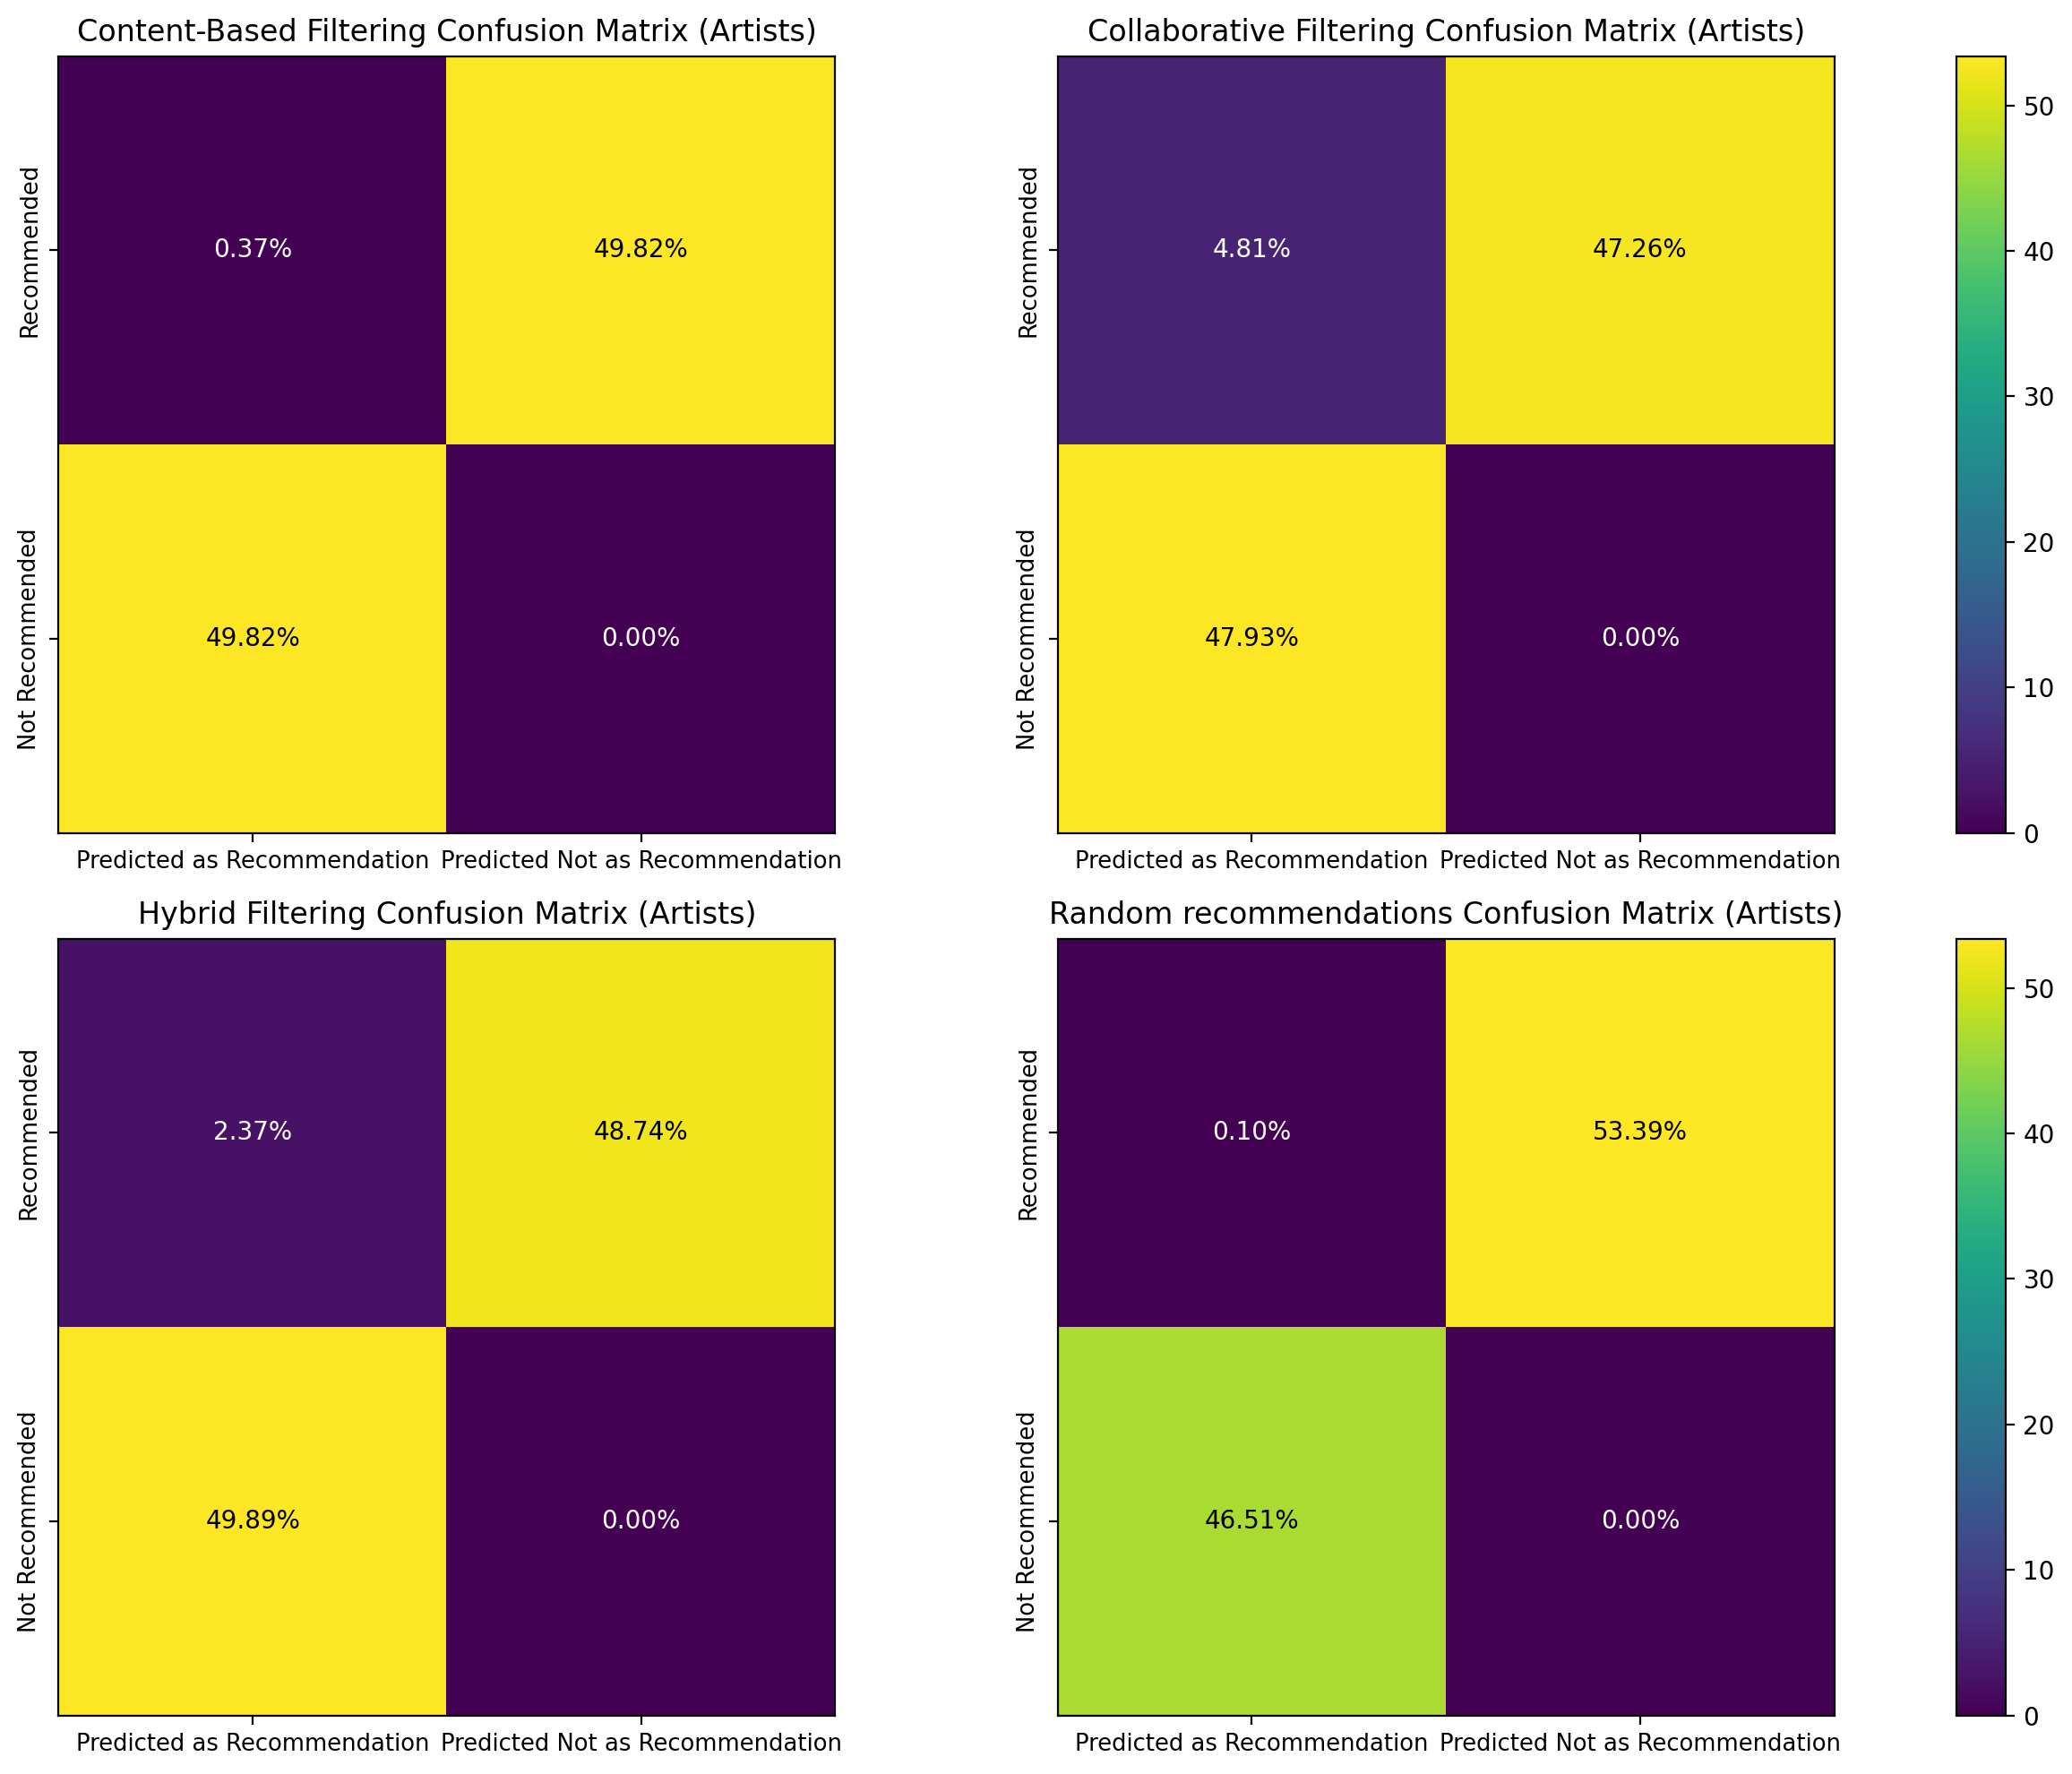

In [36]:
# TP, FN, FP Artists
conf_CB_artists = np.array([[0.37, 49.82], [49.82, 0]])
conf_CF_artists = np.array([[4.81, 47.26], [47.93, 0]]) 
conf_HF_artists = np.array([[2.37, 48.74], [49.89, 0]]) 
conf_random_artists = np.array([[0.095, 53.39], [46.51, 0]]) 

classes = ['Recommended', 'Not Recommended']
classes_pred = ['Predicted as Recommendation', 'Predicted Not as Recommendation']

conf_matrices = [conf_CB_artists, conf_CF_artists, conf_HF_artists, conf_random_artists]
method_names = ['Content-Based Filtering', 'Collaborative Filtering', 'Hybrid Filtering', 'Random recommendations'] 

plt.figure(figsize=(12, 10), dpi = 200)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[2, 2])

for i in range(len(conf_matrices)):
    row = i // 2
    col = i % 2
    ax = plt.subplot(gs[row, col])
    
    im = ax.imshow(conf_matrices[i], interpolation='nearest', cmap='viridis')
    
    tick_marks = np.arange(len(classes_pred))
    
    for m in range(len(classes)):
        for n in range(len(classes)):
            percentage = conf_matrices[i][m, n]
            text_color = 'black' if percentage > 45 else 'white'
            ax.text(n, m, f'{percentage:.2f}%', ha='center', va='center', color=text_color)

    ax.set_title(f'{method_names[i]} Confusion Matrix (Artists)')
    
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(classes_pred, fontsize=9.3, ha='center')
    ax.set_yticklabels(classes, fontsize=9.3, va='center', rotation=90)

# Add colorbar for the top two matrices
cbar_ax_top = plt.subplot(gs[0, 2])
cbar_top = plt.colorbar(im, cax=cbar_ax_top)

# Add colorbar for the bottom two matrices
cbar_ax_bottom = plt.subplot(gs[1, 2])
cbar_bottom = plt.colorbar(im, cax=cbar_ax_bottom)

plt.tight_layout()
#plt.savefig('Confusion Matrix Tuned Artist.png')
plt.show()

#### Genres

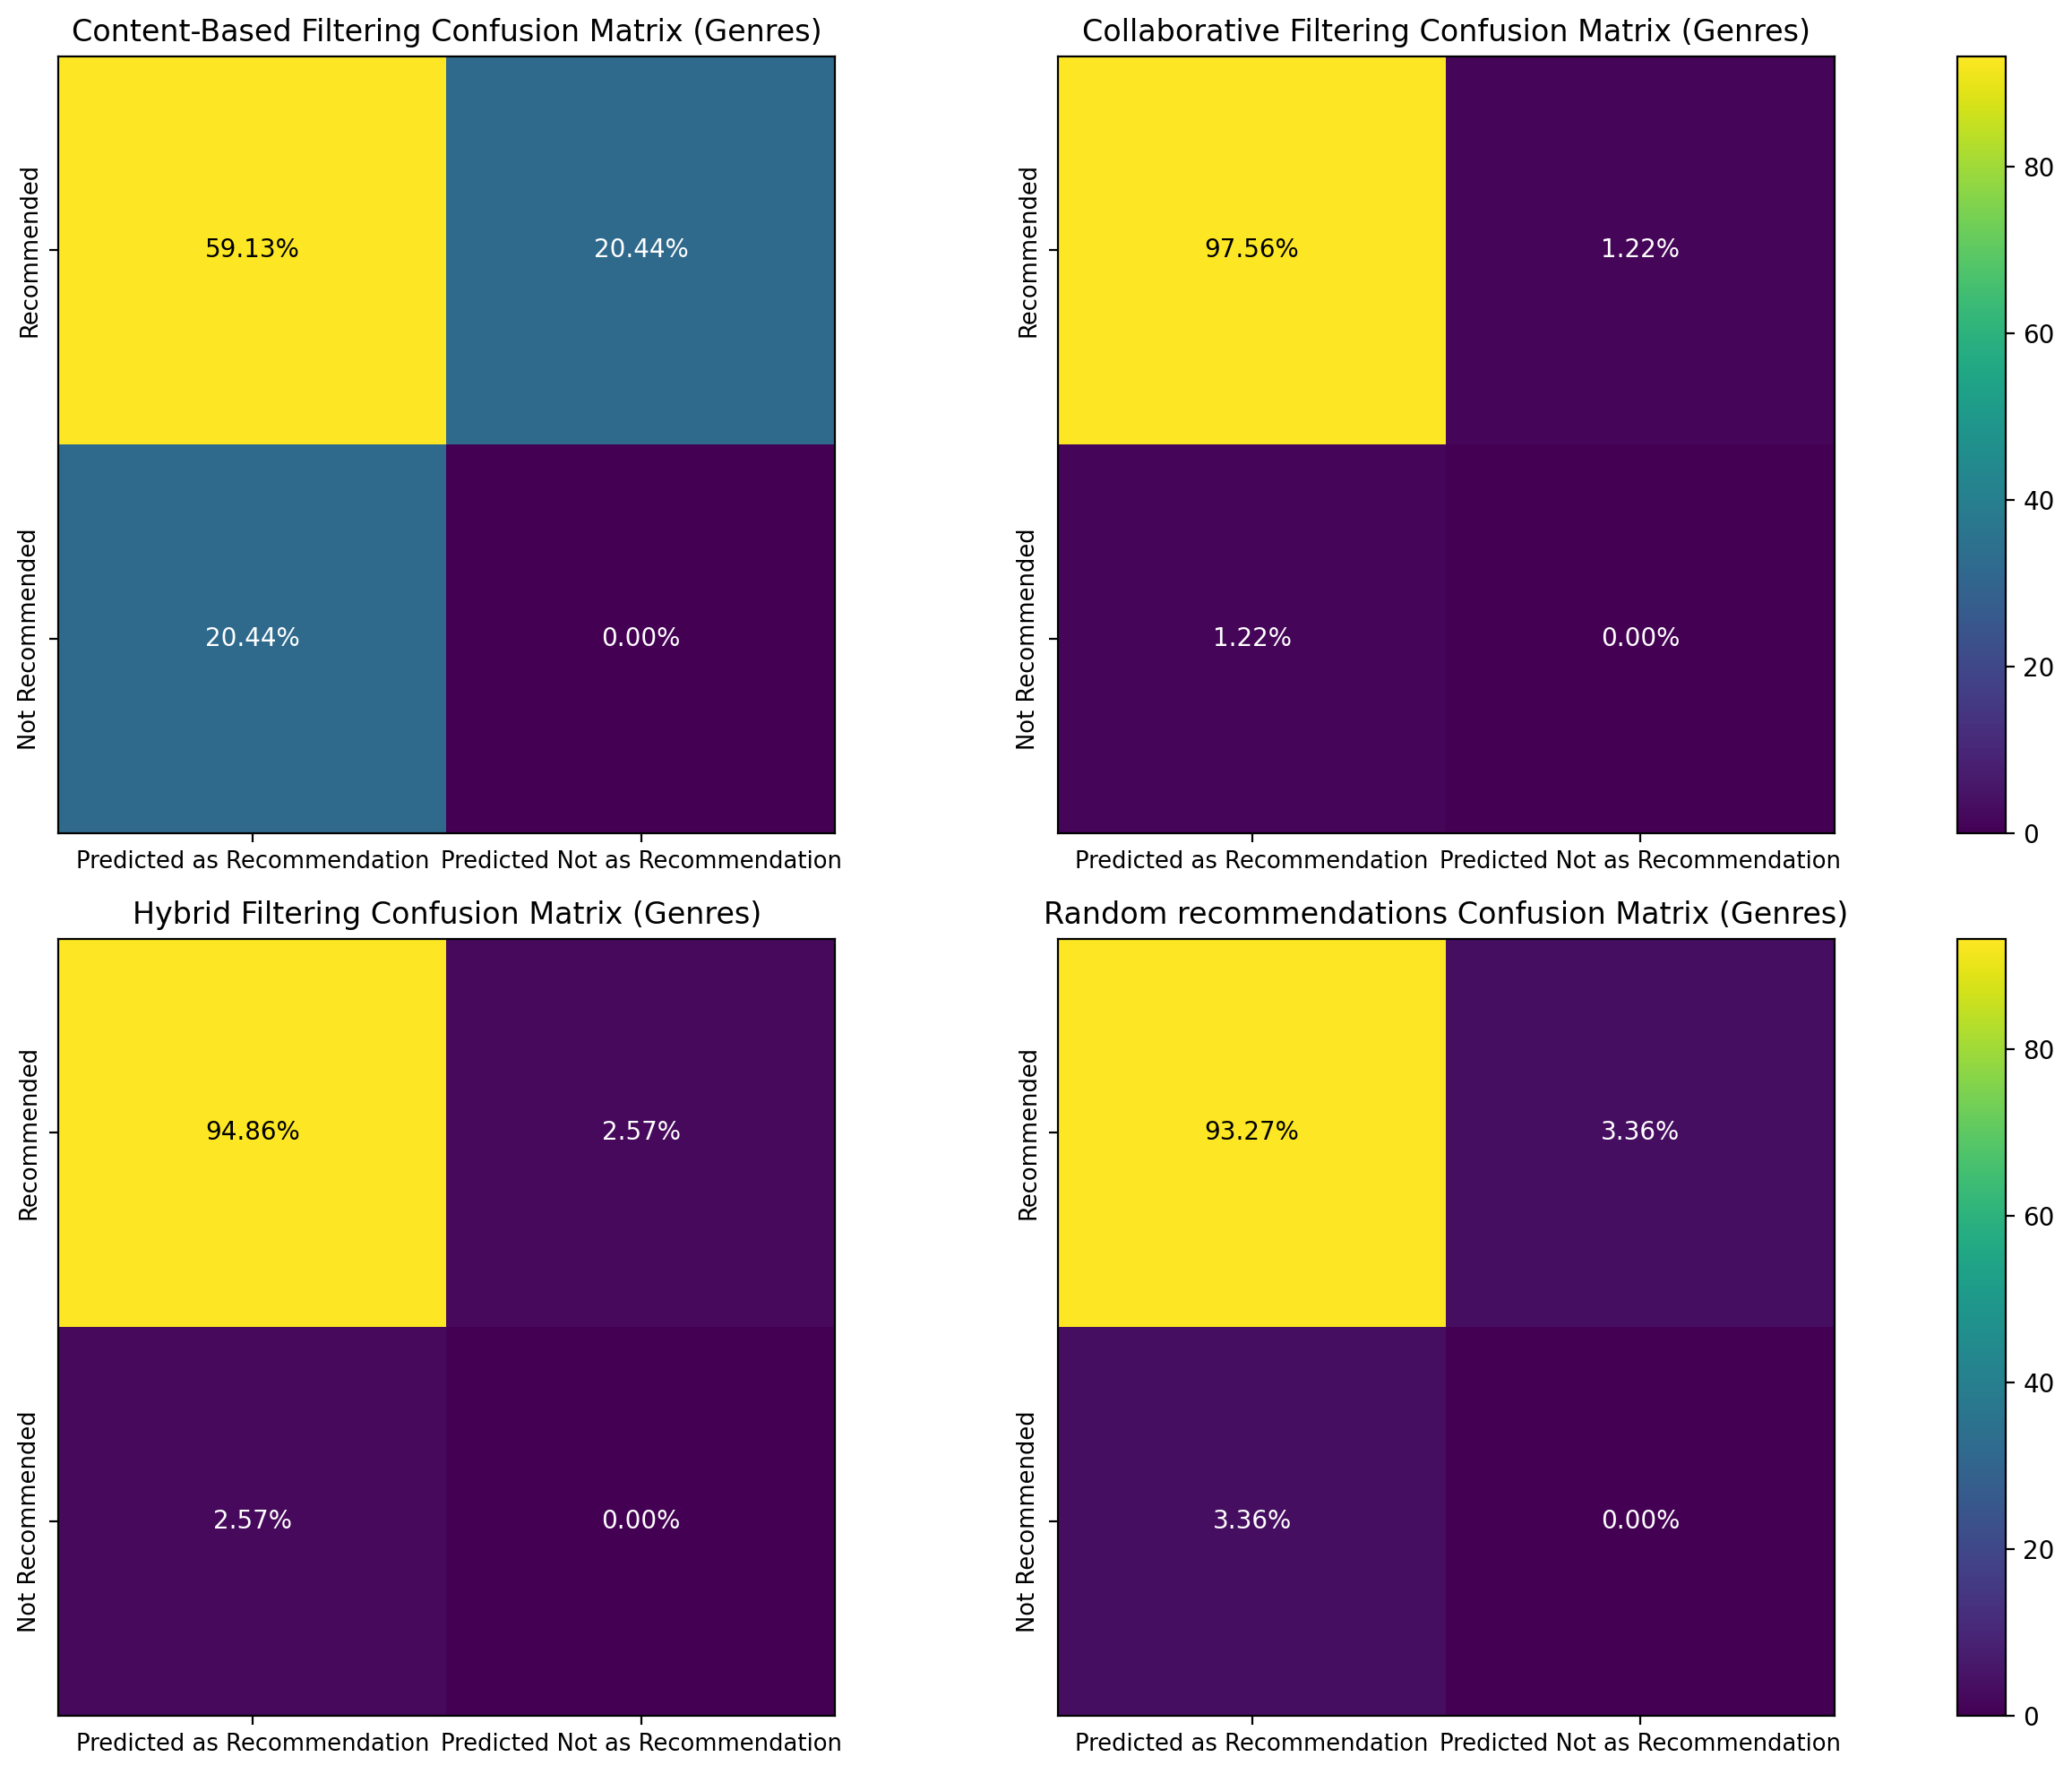

In [37]:
conf_CB_genres = np.array([[59.13, 20.44], [20.44, 0]])  
conf_CF_genres = np.array([[97.56, 1.22], [1.22, 0]])  
conf_HF_genres = np.array([[94.86, 2.57], [2.57, 0]]) 
conf_random_genres = np.array([[93.27, 3.36], [3.36, 0]]) 

classes = ['Recommended', 'Not Recommended']
classes_pred = ['Predicted as Recommendation', 'Predicted Not as Recommendation']

conf_matrices = [conf_CB_genres, conf_CF_genres, conf_HF_genres, conf_random_genres]
method_names = ['Content-Based Filtering', 'Collaborative Filtering', 'Hybrid Filtering', 'Random recommendations'] 

plt.figure(figsize=(12, 10), dpi = 200)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[2, 2])

for i in range(len(conf_matrices)):
    row = i // 2
    col = i % 2
    ax = plt.subplot(gs[row, col])
    
    im = ax.imshow(conf_matrices[i], interpolation='nearest', cmap='viridis')
    
    tick_marks = np.arange(len(classes_pred))
    
    for m in range(len(classes)):
        for n in range(len(classes)):
            percentage = conf_matrices[i][m, n]
            text_color = 'black' if percentage > 45 else 'white'
            ax.text(n, m, f'{percentage:.2f}%', ha='center', va='center', color=text_color)

    ax.set_title(f'{method_names[i]} Confusion Matrix (Genres)')
    
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(classes_pred, fontsize=9.3, ha='center')
    ax.set_yticklabels(classes, fontsize=9.3, va='center', rotation=90)

# Add colorbar for the top two matrices
cbar_ax_top = plt.subplot(gs[0, 2])
cbar_top = plt.colorbar(im, cax=cbar_ax_top)

# Add colorbar for the bottom two matrices
cbar_ax_bottom = plt.subplot(gs[1, 2])
cbar_bottom = plt.colorbar(im, cax=cbar_ax_bottom)


plt.tight_layout()
#plt.savefig('Confusion Matrix Tuned Genres.png')
plt.show()

### 5.1.2 Confusion Matrix Age Groups

#### Artists

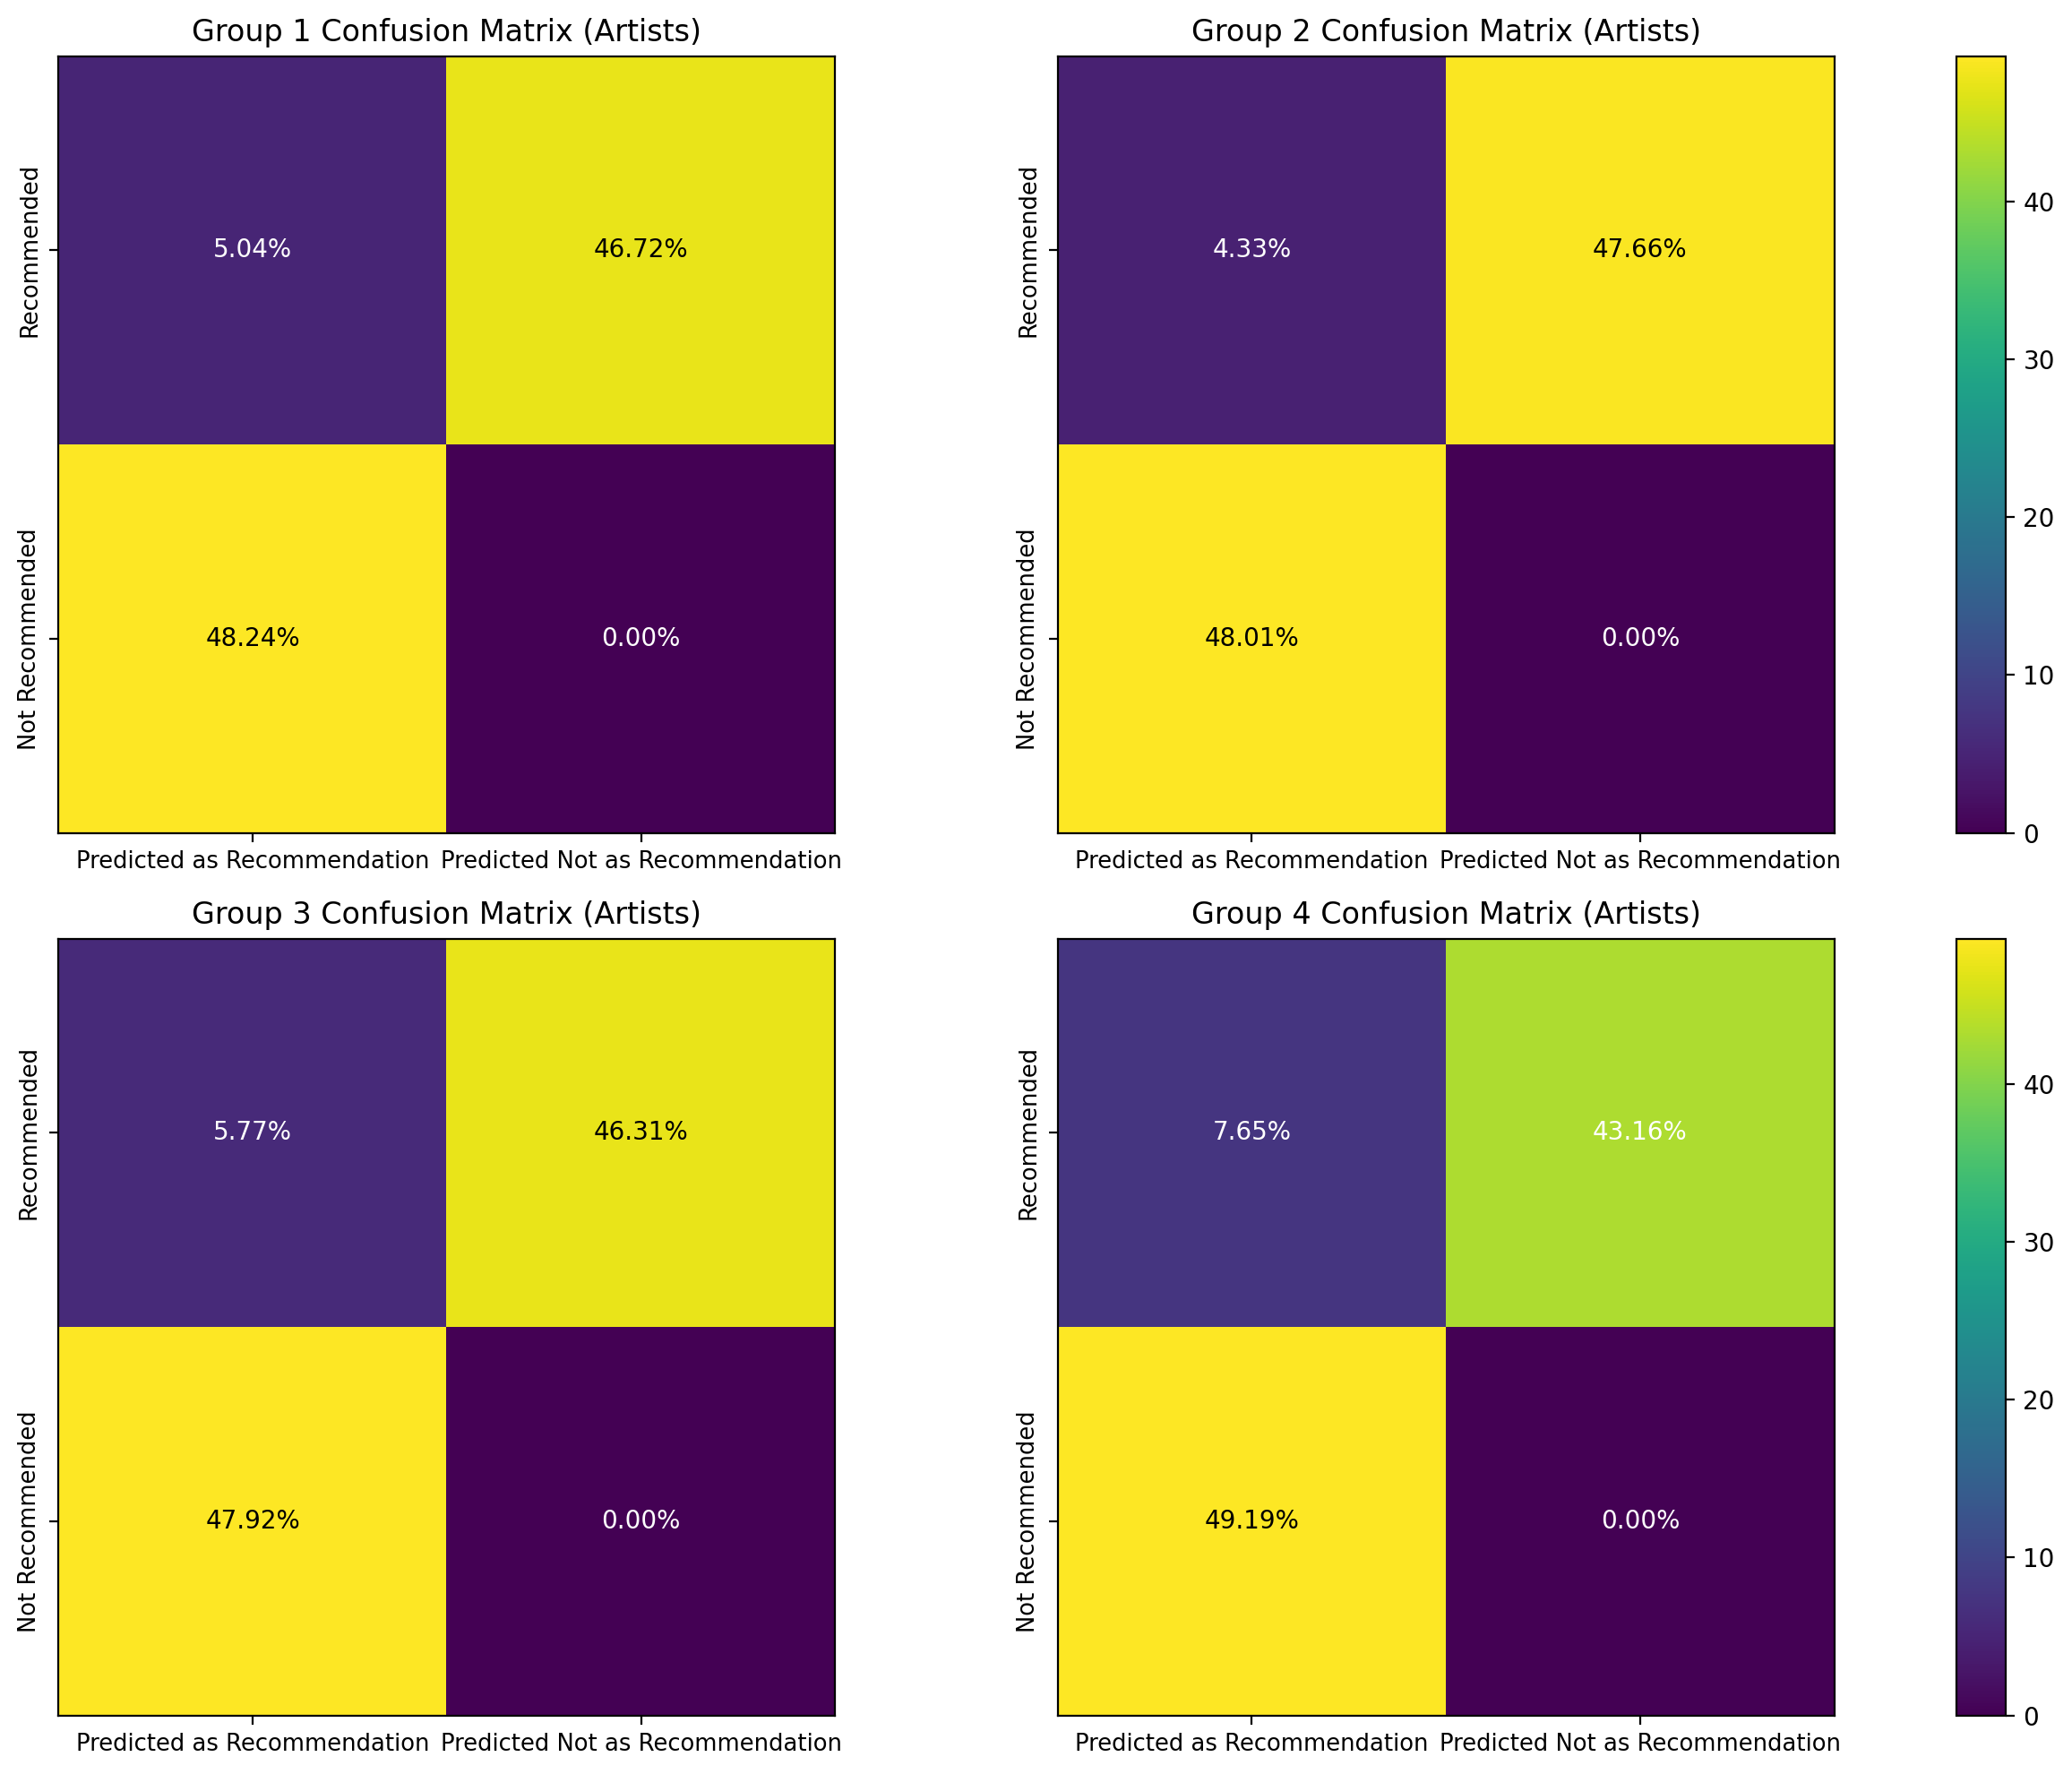

In [38]:
conf_group1_artists = np.array([[5.04, 46.72], [48.24, 0]])  
conf_group2_artists = np.array([[4.33, 47.66], [48.01, 0]])  
conf_group3_artists = np.array([[5.77, 46.31], [47.92, 0]]) 
conf_group4_artists = np.array([[7.65, 43.16], [49.19, 0]]) 

classes = ['Recommended', 'Not Recommended']
classes_pred = ['Predicted as Recommendation', 'Predicted Not as Recommendation']

conf_matrices = [conf_group1_artists, conf_group2_artists, conf_group3_artists, conf_group4_artists]
group_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4'] 

plt.figure(figsize=(12, 10), dpi=200)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[2, 2])

for i in range(len(conf_matrices)):
    row = i // 2
    col = i % 2
    ax = plt.subplot(gs[row, col])
    
    im = ax.imshow(conf_matrices[i], interpolation='nearest', cmap='viridis')
    
    tick_marks = np.arange(len(classes_pred))
    
    for m in range(len(classes)):
        for n in range(len(classes)):
            percentage = conf_matrices[i][m, n]
            text_color = 'black' if percentage > 45 else 'white'
            ax.text(n, m, f'{percentage:.2f}%', ha='center', va='center', color=text_color)

    ax.set_title(f'{group_names[i]} Confusion Matrix (Artists)')
    
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(classes_pred, fontsize=9.3, ha='center')
    ax.set_yticklabels(classes, fontsize=9.3, va='center', rotation=90)

# Add colorbar for the top two matrices
cbar_ax_top = plt.subplot(gs[0, 2])
cbar_top = plt.colorbar(im, cax=cbar_ax_top)

# Add colorbar for the bottom two matrices
cbar_ax_bottom = plt.subplot(gs[1, 2])
cbar_bottom = plt.colorbar(im, cax=cbar_ax_bottom)


plt.tight_layout()
#plt.savefig('Confusion Matrix Age Groups Artists.png')
plt.show()

#### Genres

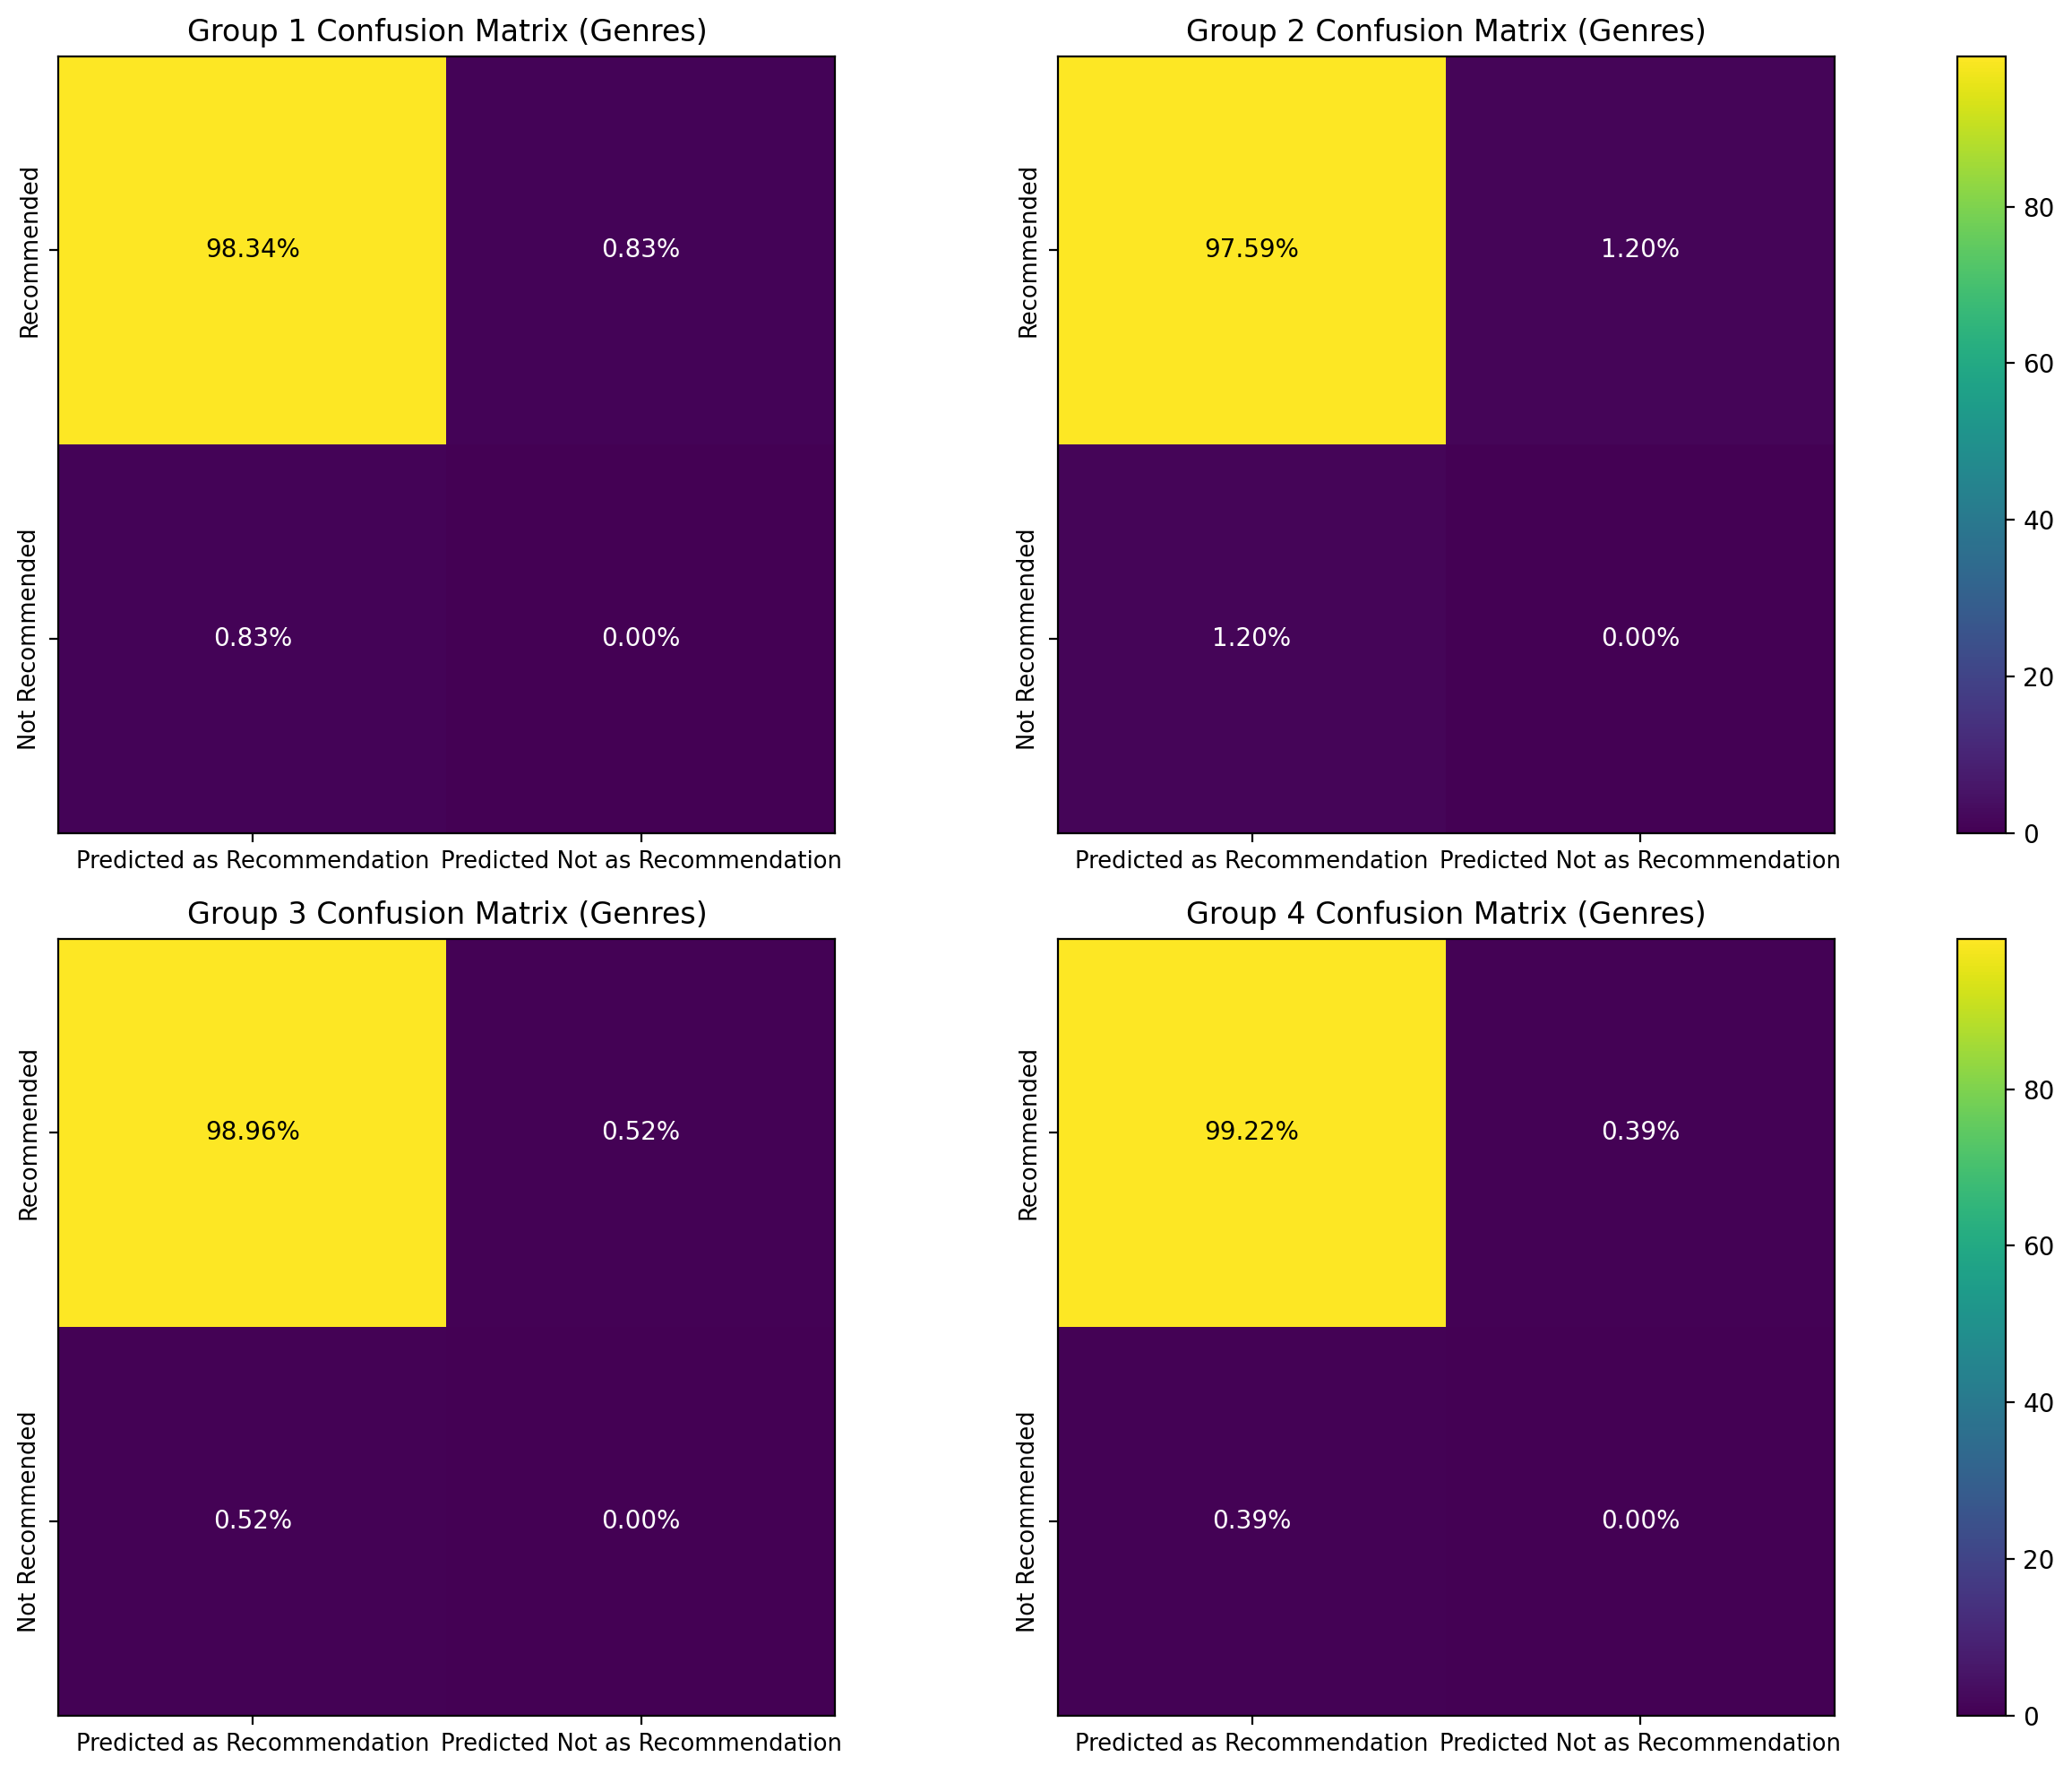

In [39]:
conf_group1_genres = np.array([[98.34, 0.83], [0.83, 0]])  
conf_group2_genres = np.array([[97.59, 1.2], [1.2, 0]])  
conf_group3_genres = np.array([[98.96, 0.52], [0.52, 0]]) 
conf_group4_genres = np.array([[99.22, 0.39], [0.39, 0]]) 

classes = ['Recommended', 'Not Recommended']
classes_pred = ['Predicted as Recommendation', 'Predicted Not as Recommendation']

conf_matrices = [conf_group1_genres, conf_group2_genres, conf_group3_genres, conf_group4_genres]
group_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4'] 

plt.figure(figsize=(12, 10), dpi=200)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[2, 2])

for i in range(len(conf_matrices)):
    row = i // 2
    col = i % 2
    ax = plt.subplot(gs[row, col])
    
    im = ax.imshow(conf_matrices[i], interpolation='nearest', cmap='viridis')
    
    tick_marks = np.arange(len(classes_pred))
    
    for m in range(len(classes)):
        for n in range(len(classes)):
            percentage = conf_matrices[i][m, n]
            text_color = 'black' if percentage > 45 else 'white'
            ax.text(n, m, f'{percentage:.2f}%', ha='center', va='center', color=text_color)

    ax.set_title(f'{group_names[i]} Confusion Matrix (Genres)')
    
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(classes_pred, fontsize=9.3, ha='center')
    ax.set_yticklabels(classes, fontsize=9.3, va='center', rotation=90)

# Add colorbar for the top two matrices
cbar_ax_top = plt.subplot(gs[0, 2])
cbar_top = plt.colorbar(im, cax=cbar_ax_top)

# Add colorbar for the bottom two matrices
cbar_ax_bottom = plt.subplot(gs[1, 2])
cbar_bottom = plt.colorbar(im, cax=cbar_ax_bottom)


plt.tight_layout()
#plt.savefig('Confusion Matrix Age Groups Genres.png')
plt.show()

## 5.2 Radar Charts

### 5.2.1 Tuned Models with k = 25

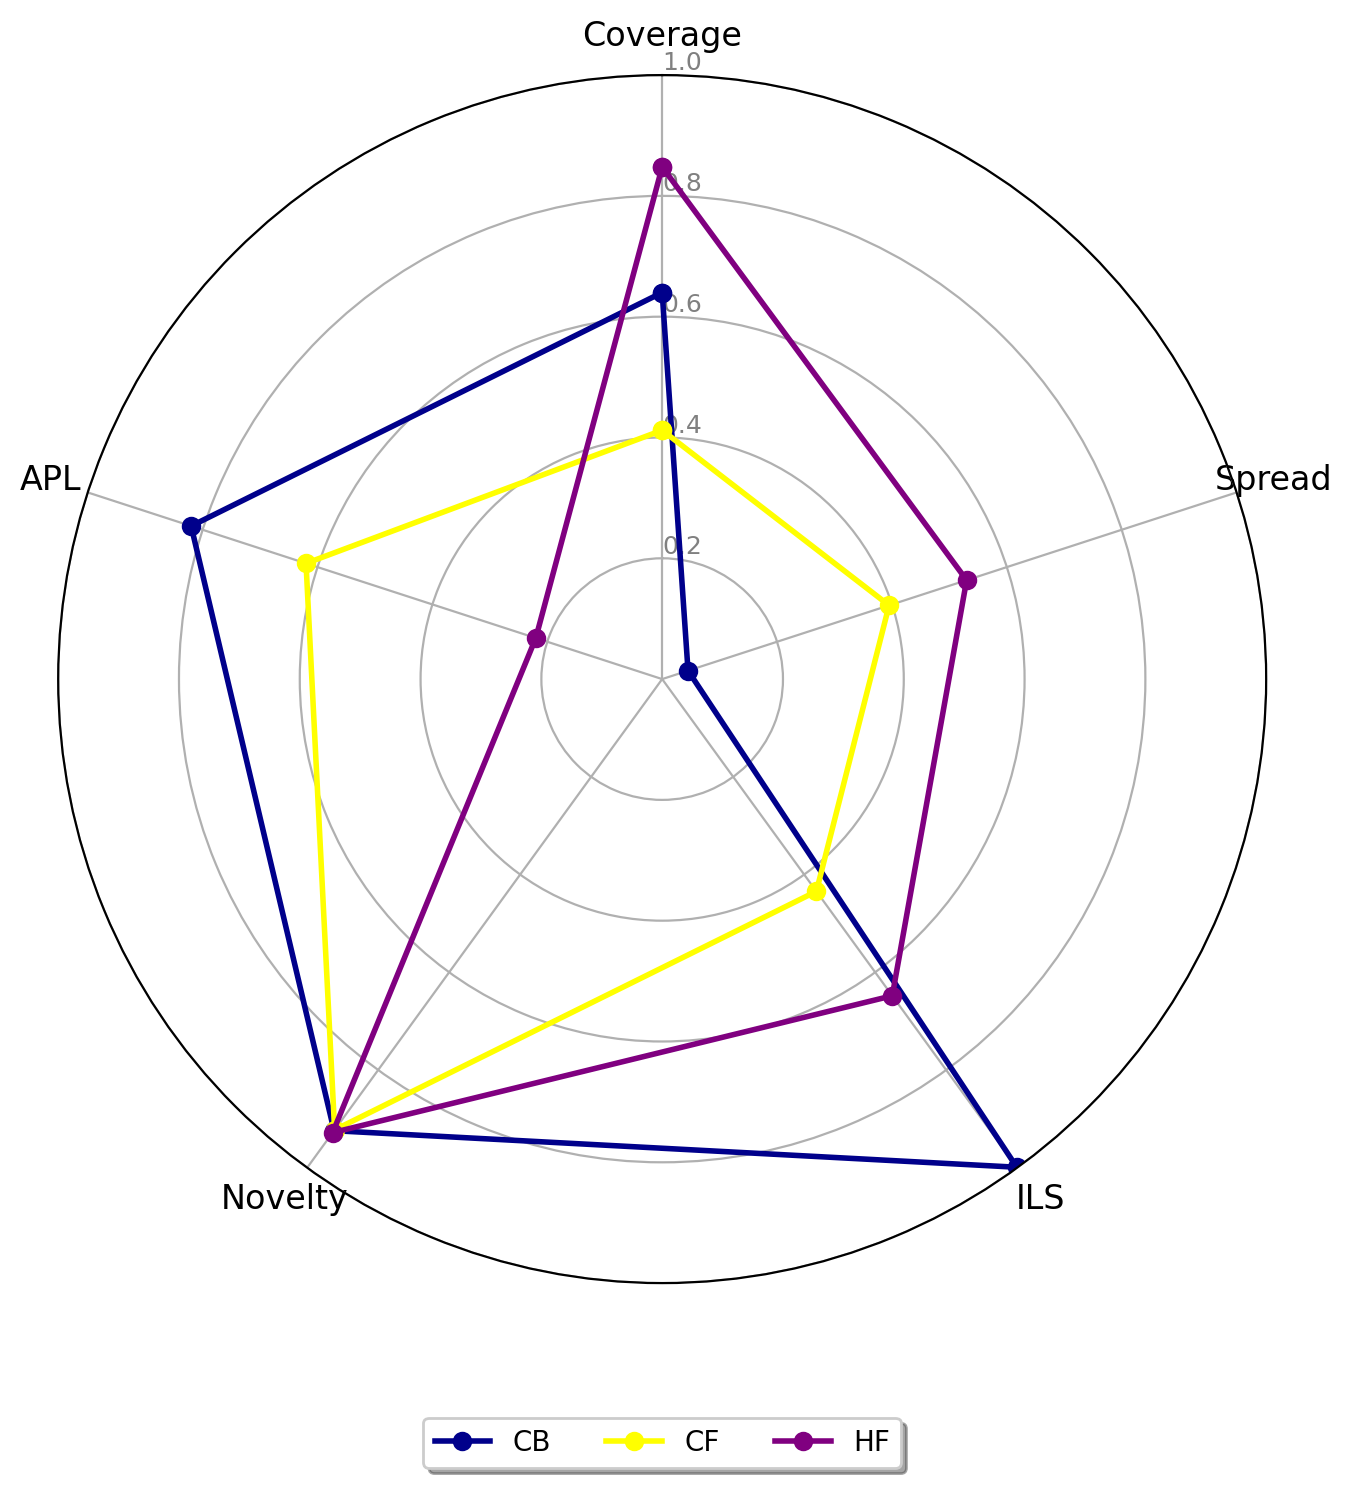

In [40]:
# Metrics and values
metrics = ['Coverage', 'Spread', 'ILS', 'Novelty', 'APL']

# CHANGE!
values_CB = [0.0160, 0.009, 0.999, 0.6007, 0.041]
values_CF = [0.0103, 0.079, 0.4344, 0.5997, 0.031]
values_HF = [0.0212, 0.106, 0.6481, 0.6033, 0.011]

# Custom max values for normalization (one per metric)
custom_max_values = [0.025, 0.2, 1.0, 0.65, 0.05]

# Normalize values for each metric using custom max values
values_CB_normalized = [val / max_val for val, max_val in zip(values_CB, custom_max_values)]
values_CF_normalized = [val / max_val for val, max_val in zip(values_CF, custom_max_values)]
values_HF_normalized = [val / max_val for val, max_val in zip(values_HF, custom_max_values)]

# Number of metrics
num_metrics = len(metrics)

# Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Repeat the first value to close the circle
values_CB_normalized += values_CB_normalized[:1]
values_CF_normalized += values_CF_normalized[:1]
values_HF_normalized += values_HF_normalized[:1]
angles += angles[:1]

# Plot outlines only
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi = 200)
ax.plot(angles, values_CB_normalized, 'darkblue', marker='o', linestyle='-', linewidth=2, label='CB')
ax.plot(angles, values_CF_normalized, 'yellow', marker='o', linestyle='-', linewidth=2, label='CF')
ax.plot(angles, values_HF_normalized, 'purple', marker='o', linestyle='-', linewidth=2, label='HF')

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(0)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics, fontsize=12)

plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=9)
plt.ylim(0, 1)

# Move legend to the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize='medium')
#plt.savefig('Radar Chart Methods (tuned 25)')
plt.show()

### 5.2.2 Age Groups

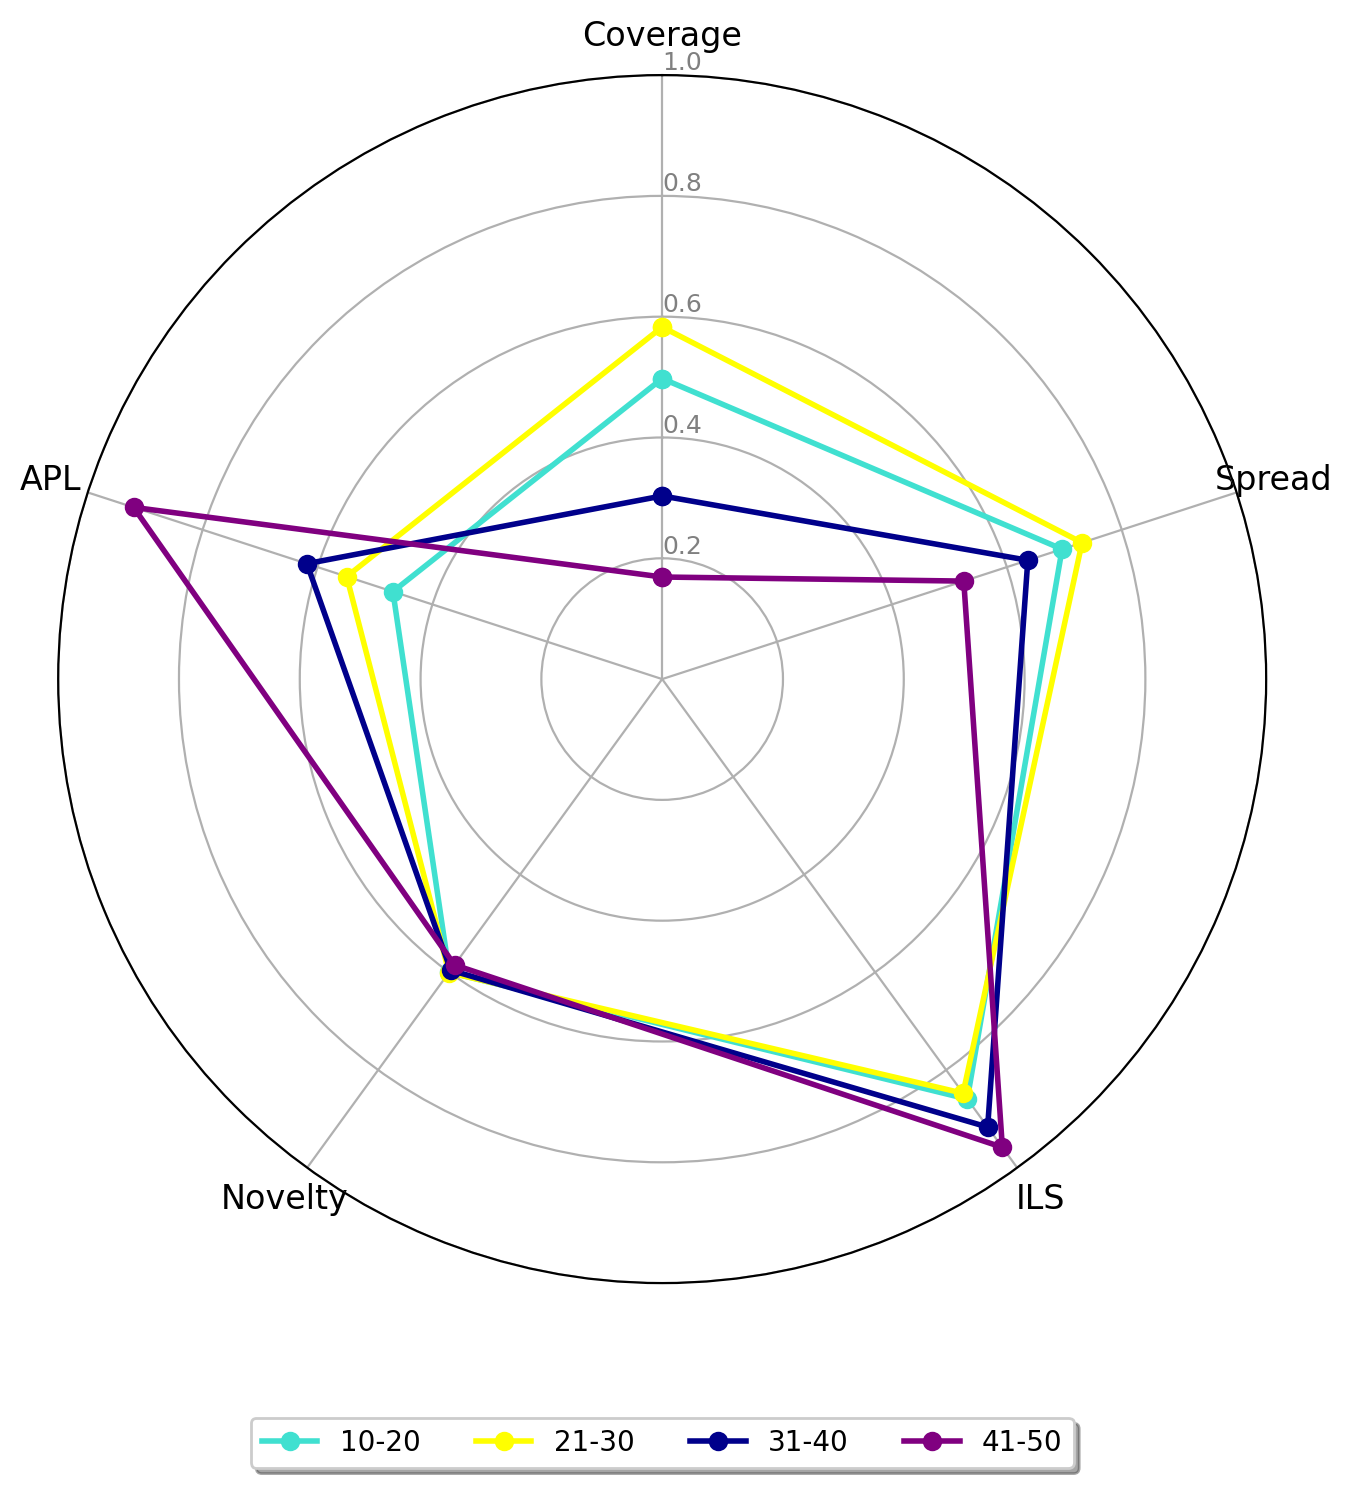

In [41]:
# Metrics and values
metrics = ['Coverage', 'Spread', 'ILS', 'Novelty', 'APL']

# CHANGE!
values_group1 = [0.009952, 0.06961829, 0.42972375, 0.59998, 0.0234375]
values_group2 = [0.011658, 0.07309649, 0.42376007, 0.60056, 0.0274617]
values_group3 = [0.006065, 0.0636509, 0.4583832, 0.59574, 0.0309201]
values_group4 = [0.003380, 0.05250202, 0.4791079, 0.58492, 0.0460081]

# Custom max values for normalization (one per metric)
custom_max_values = [0.02, 0.1, 0.5, 1, 0.05]

# Normalize values for each metric using custom max values
values_group1_normalized = [val / max_val for val, max_val in zip(values_group1, custom_max_values)]
values_group2_normalized = [val / max_val for val, max_val in zip(values_group2, custom_max_values)]
values_group3_normalized = [val / max_val for val, max_val in zip(values_group3, custom_max_values)]
values_group4_normalized = [val / max_val for val, max_val in zip(values_group4, custom_max_values)]

# Number of metrics
num_metrics = len(metrics)

# Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Repeat the first value to close the circle
values_group1_normalized += values_group1_normalized[:1]
values_group2_normalized += values_group2_normalized[:1]
values_group3_normalized += values_group3_normalized[:1]
values_group4_normalized += values_group4_normalized[:1]
angles += angles[:1]

# Plot outlines only
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi=200)
ax.plot(angles, values_group1_normalized, 'turquoise', marker='o', linestyle='-', linewidth=2, label='10-20')
ax.plot(angles, values_group2_normalized, 'yellow', marker='o', linestyle='-', linewidth=2, label='21-30')
ax.plot(angles, values_group3_normalized, 'darkblue', marker='o', linestyle='-', linewidth=2, label='31-40')
ax.plot(angles, values_group4_normalized, 'purple', marker='o', linestyle='-', linewidth=2, label='41-50')

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(0)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics, fontsize=12)

plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=9)
plt.ylim(0, 1)

# Move legend to the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4, fontsize='medium')
#plt.savefig('Radar Chart Age Groups.png')
plt.show()